In [17]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
import os
import logging
import json
import re
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from IPython.display import Image, display
from datetime import datetime
import torch
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Azure OpenAI configuration
os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

In [18]:
class CodeGenerationState(TypedDict):
    """State management for code generation process"""
    messages: Annotated[list[AnyMessage], operator.add]
    current_code: str
    validation_status: bool
    error_messages: list[str]
    is_valid: bool  # Using is_valid to match the notebook's conditional edge structure

In [19]:
# Define prompts
developer_prompt = """
Role: Python Developer
Task: Generate complete, production-ready Python code based on the requirements specification.

Requirements:
{requirements}

Your code must include:
1. All necessary imports and dependencies
2. Complete implementation with:
   - Well-structured classes and functions
   - Configuration management (using dataclasses or similar)
   - Comprehensive error handling and validation
   - Type hints throughout
   - Logging with appropriate levels
   - Unit tests where applicable
3. Clear documentation:
   - Module docstrings
   - Function/method docstrings with parameters and return values
   - Inline comments for complex logic

Focus on implementing EVERY aspect mentioned in the requirements. Do not leave any required functionality unimplemented.

## Output Format
Your response should be the complete, production-ready Python code without surrounding explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:

# Your Python code here
"""

validator_prompt = """
Role: Senior Code Reviewer
Task: Perform a thorough validation of the provided Python code against the requirements.

Requirements:
{Requirements}

Validation Process:
1. Carefully compare the code against EACH requirement in the specification
2. For each requirement, determine if it has been fully, partially, or not implemented
3. Identify any missing functionality, edge cases, or requirements
4. Evaluate code quality, error handling, security, and performance

Validation Checklist:
1. Code Completeness:
   - All imports and dependencies present
   - Full implementation of required functionality (check EACH requirement)
   - No placeholder code or TODOs

2. Code Quality:
   - Follows PEP 8 standards
   - Clear variable/function naming
   - Appropriate modularization
   - Avoids code duplication
   - Maintainable architecture

3. Technical Implementation:
   - Proper error handling with specific exceptions
   - Complete type annotations
   - Correct algorithm implementation
   - Efficient resource usage
   - Security considerations addressed

4. Documentation:
   - Comprehensive docstrings
   - Clear inline comments where needed

## Output Format
Return your validation report as a structured JSON object with the following format:

```json
{{
  "validation_report": {{
    "overall_assessment": "Pass/Fail",
    "issues_found": [
      "Issue 1 description",
      "Issue 2 description",
      "..."
    ],
    "suggested_improvements": [
      {{
        "description": "Improvement 1",
        "priority": "high/medium/low"
      }},
      "..."
    ],
    "implementation_vs_requirements": {{
      "match": true/false,
      "details": [
        {{
          "requirement_section": "Requirement name/section",
          "status": "Implemented/Partially Implemented/Not Implemented",
          "notes": "Notes about implementation"
        }},
        "..."
      ]
    }}
  }}
}}

Be strict in your assessment. If ANY requirement is not fully implemented, the overall assessment should be "Fail".
"""


corrector_prompt = """
Role: Senior Python Developer
Task: Refactor and fix the code based on the validation feedback.
Original Requirements:
{requirements}
Validation Feedback:
{ValidationFeedback}
Correction Instructions:

Address ALL issues identified in the validation feedback
Pay particular attention to any requirements marked as "Not Implemented" or "Partially Implemented"
Maintain the original architectural approach unless fundamentally flawed
Ensure complete implementation of ALL requirements from the original specification
Add or improve:

Error handling for all edge cases
Type hints throughout the codebase
Documentation (docstrings and comments)
Logging for important operations
Performance optimizations where possible



Important: Make sure you implement EVERY feature mentioned in the requirements that was flagged as missing or incomplete in the validation feedback.
Output Format
Your response should be the complete, corrected, production-ready Python code without explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:
Your corrected Python code here
"""

In [20]:
class CodeGenerator:
    """Main class for generating, validating, and correcting code"""
    
    def __init__(self, model, checkpointer, system_developer="", system_validator="", system_corrector=""):
        self.system_developer = system_developer
        self.system_validator = system_validator
        self.system_corrector = system_corrector
        
        # Create output directory
        self.output_dir = f"code_generation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Initialize graph
        graph = StateGraph(CodeGenerationState)
        
        # Add nodes
        graph.add_node("developer", self.developer)
        graph.add_node("validator", self.validator)
        graph.add_node("correction", self.correction)
        
        # Add edges
        graph.add_edge("developer", "validator")
        
        # Add conditional edges (matching notebook pattern)
        graph.add_conditional_edges(
            "validator", 
            lambda state: state["is_valid"],
            {
                True: END,
                False: "correction"
            }
        )
        
        graph.add_edge("correction", END)
        
        # Set entry point
        graph.set_entry_point("developer")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.model = model
        
        # Try to display graph visualization if possible
        try:
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception:
            pass

    def extract_code(self, text):
        """Extract code from between triple backticks or triple single quotes"""
        pattern = r"```(?:python)?\\s*(.*?)```"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        # Try with triple single quotes
        pattern = r"'''(?:python)?\\s*(.*?)'''"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        return text  # Return original if no code blocks found

    def save_code_attempt(self, code: str, status: str = "initial") -> str:
        """Save code attempt and return directory path"""
        attempt_dir = os.path.join(self.output_dir, f"attempt_{status}")
        os.makedirs(attempt_dir, exist_ok=True)
        
        # Save code
        code_file = os.path.join(attempt_dir, "code.py")
        with open(code_file, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved code attempt to {code_file}")
        return attempt_dir

    def developer(self, state: CodeGenerationState):
        """Generate initial code"""
        messages = state['messages']
        print(messages)
        print("developer", "*" * 50)
        
        if self.system_developer:
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_developer.format(
                requirements=messages[0].content,  # Changed from Requirements to requirements
                TechnicalSpecifications=messages[0].content
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        
        # Extract code from response
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save code
        self.save_code_attempt(code_only)
        
        return {
            'messages': [message],
            'current_code': code_only,
            'validation_status': None,
            'error_messages': [],
            'is_valid': False
        }

    def validator(self, state: CodeGenerationState):
        """Validate generated code"""
        messages = state.get('messages', [])
        current_code = state.get('current_code', '')
        
        print(messages)
        print("validate", "*" * 50)
        
        if self.system_validator:
            original_message = state["messages"][0].content if state["messages"] else ""
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_validator.format(
                Requirements=original_message,
                TechnicalSpecifications=original_message
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "").lower()
        
        # Attempt to determine if validation passed by extracting JSON
        is_valid = False
        try:
            # Try to extract JSON from the message
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                is_valid = (validation_json.get("validation_report", {}).get("overall_assessment", "").lower() == "pass")
        except:
            # Fallback to the original logic if JSON extraction fails
            is_valid = "pass" in response_text and "correctly implements" in response_text
        
        # Save validation results to JSON if possible
        try:
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                json_path = os.path.join(self.output_dir, "validation_results.json")
                with open(json_path, 'w') as f:
                    json.dump(validation_json, f, indent=2)
                logger.info(f"Saved validation results to {json_path}")
        except Exception as e:
            logger.error(f"Failed to save validation results: {e}")
        
        if is_valid:
            self.save_code_attempt(current_code, "validated_pass")
        else:
            self.save_code_attempt(current_code, "validated_fail")
            
        return {
            'messages': [message],
            'current_code': current_code,
            'is_valid': is_valid,
            'error_messages': [] if is_valid else ["Validation failed"]
        }

    def correction(self, state: CodeGenerationState):
        """Correct code based on validation feedback"""
        messages = state['messages']
        
        print(messages)
        print("correction", "*" * 50)
        
        if self.system_corrector:
            # Get original requirements from the first human message in the chain
            original_requirements = ""
            for msg in state['messages']:
                if isinstance(msg, HumanMessage) and msg.content:
                    original_requirements = msg.content
                    break
            
            # Get validation feedback from the most recent message
            validation_feedback = messages[0].content if messages else ""
            
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_corrector.format(
                requirements=original_requirements,  # Changed from Requirements to requirements
                ValidationFeedback=validation_feedback
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save corrected code
        self.save_code_attempt(code_only, "correction")
        
        return {
            'messages': [message],
            'current_code': code_only,
            'is_valid': False,
            'error_messages': []
        }

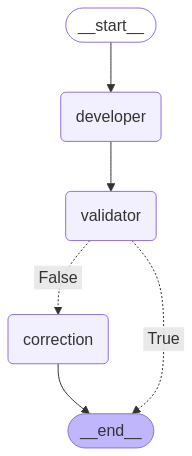

[HumanMessage(content='\n## 1. **Overview**  \nThis technical specification provides a detailed plan for implementing a feature that allows users to upload training datasets from local storage to a cloud training bucket, validate the datasets for integrity and structure, and provide real-time feedback. It addresses all functional requirements, edge cases, and non-functional requirements.\n \n---\n \n## 2. **System Architecture**  \n \n### 2.1 **High-Level Architecture**  \nThe system consists of the following components:  \n1. **Frontend Module**: Provides the user interface for file selection, dataset type input, and real-time feedback display.  \n2. **Backend API**: Handles dataset validation, file extraction, cloud upload, and feedback delivery.  \n3. **Cloud Storage Module**: Stores validated datasets securely.  \n4. **Validation Module**: Performs structural, file integrity, and format validation.  \n \n---\n \n### 2.2 **Component Breakdown**  \n \n#### **Frontend Module**  \n- **

2025-03-04 16:47:59,498 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-04 16:47:59,500 - __main__ - INFO - [4021668688.py:72] - Saved code attempt to code_generation_20250304_164704/attempt_initial/code.py


[HumanMessage(content='\n## 1. **Overview**  \nThis technical specification provides a detailed plan for implementing a feature that allows users to upload training datasets from local storage to a cloud training bucket, validate the datasets for integrity and structure, and provide real-time feedback. It addresses all functional requirements, edge cases, and non-functional requirements.\n \n---\n \n## 2. **System Architecture**  \n \n### 2.1 **High-Level Architecture**  \nThe system consists of the following components:  \n1. **Frontend Module**: Provides the user interface for file selection, dataset type input, and real-time feedback display.  \n2. **Backend API**: Handles dataset validation, file extraction, cloud upload, and feedback delivery.  \n3. **Cloud Storage Module**: Stores validated datasets securely.  \n4. **Validation Module**: Performs structural, file integrity, and format validation.  \n \n---\n \n### 2.2 **Component Breakdown**  \n \n#### **Frontend Module**  \n- **

2025-03-04 16:47:59,962 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-04 16:47:59,962 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 6.000000 seconds
2025-03-04 16:48:16,078 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-04 16:48:16,080 - __main__ - INFO - [4021668688.py:148] - Saved validation results to code_generation_20250304_164704/validation_results.json
2025-03-04 16:48:16,081 - __main__ - INFO - [4021668688.py:72] - Saved code attempt to code_generation_20250304_164704/attempt_validated_fail/code.py


[HumanMessage(content='\n## 1. **Overview**  \nThis technical specification provides a detailed plan for implementing a feature that allows users to upload training datasets from local storage to a cloud training bucket, validate the datasets for integrity and structure, and provide real-time feedback. It addresses all functional requirements, edge cases, and non-functional requirements.\n \n---\n \n## 2. **System Architecture**  \n \n### 2.1 **High-Level Architecture**  \nThe system consists of the following components:  \n1. **Frontend Module**: Provides the user interface for file selection, dataset type input, and real-time feedback display.  \n2. **Backend API**: Handles dataset validation, file extraction, cloud upload, and feedback delivery.  \n3. **Cloud Storage Module**: Stores validated datasets securely.  \n4. **Validation Module**: Performs structural, file integrity, and format validation.  \n \n---\n \n### 2.2 **Component Breakdown**  \n \n#### **Frontend Module**  \n- **

2025-03-04 16:48:16,749 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-04 16:48:16,749 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 51.000000 seconds
2025-03-04 16:49:50,434 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-04 16:49:50,435 - __main__ - INFO - [4021668688.py:72] - Saved code attempt to code_generation_20250304_164704/attempt_correction/code.py


In [21]:
# Requirements specification is the technical specification document
Requirements = '''
## 1. **Overview**  
This technical specification provides a detailed plan for implementing a feature that allows users to upload training datasets from local storage to a cloud training bucket, validate the datasets for integrity and structure, and provide real-time feedback. It addresses all functional requirements, edge cases, and non-functional requirements.
 
---
 
## 2. **System Architecture**  
 
### 2.1 **High-Level Architecture**  
The system consists of the following components:  
1. **Frontend Module**: Provides the user interface for file selection, dataset type input, and real-time feedback display.  
2. **Backend API**: Handles dataset validation, file extraction, cloud upload, and feedback delivery.  
3. **Cloud Storage Module**: Stores validated datasets securely.  
4. **Validation Module**: Performs structural, file integrity, and format validation.  
 
---
 
### 2.2 **Component Breakdown**  
 
#### **Frontend Module**  
- **Responsibilities**:  
  - Allow users to select a zip file and dataset type.  
  - Provide real-time progress updates for file upload and validation processes.  
  - Display success, warning, or error messages.  
- **Technologies**:  
  - React.js or Angular for UI.  
  - WebSocket or Server-Sent Events (SSE) for real-time feedback.  
  - Axios or Fetch API for communication with the backend.  
 
#### **Backend API**  
- **Responsibilities**:  
  - Handle dataset upload and validation requests.  
  - Manage asynchronous tasks for large file uploads and validations.  
  - Communicate real-time progress and feedback to the frontend.  
- **Technologies**:  
  - Python (FastAPI or Flask) for API development.  
  - Celery with Redis for task management.  
 
#### **Cloud Storage Module**  
- **Responsibilities**:  
  - Store datasets securely in a scalable cloud storage bucket.  
  - Use pre-signed URLs for efficient and secure file uploads.  
- **Technologies**:  
  - AWS S3, Azure Blob Storage, or Google Cloud Storage.  
  - Encryption protocols (e.g., HTTPS, TLS).  
 
#### **Validation Module**  
- **Responsibilities**:  
  - Ensure datasets meet structural and format requirements based on the selected dataset type.  
  - Validate file integrity and detect corrupted files.  
- **Technologies**:  
  - Python libraries: `os`, `zipfile`, `Pillow`, and `pyzipper`.  
 
---
 
## 3. **Detailed Design**  
 
### 3.1 **Data Structures**  
 
#### **Frontend State Management**  
```javascript
{
  file: File,  // File object selected by the user
  datasetType: "classification" | "segmentation",  // Dataset type selected by user
  progress: number,  // Progress percentage (0-100)
  feedback: {        // Real-time feedback messages
    status: "success" | "warning" | "error",
    message: string
  }
}
```
 
#### **Backend Request Body**  
```json
{
  "filePath": "/path/to/zipfile.zip",
  "datasetType": "classification"
}
```
 
#### **Validation Module Output**  
```python
{
  "is_valid": bool,        # Whether the dataset passed all validations
  "errors": list[str],     # List of validation errors
  "warnings": list[str],   # List of validation warnings
  "progress": int          # Validation progress percentage
}
```
 
---
 
### 3.2 **API Endpoints**  
 
#### **1. Upload Dataset**  
- **URL**: `/api/dataset/upload`  
- **Method**: POST  
- **Request Body**:  
  - `filePath`: Path to the zip file.  
  - `datasetType`: Type of dataset ("classification" or "segmentation").  
- **Response**:  
  ```json
  {
    "status": "success" | "error",
    "message": "Feedback message describing the operation result"
  }
  ```
 
#### **2. Validate Dataset**  
- **URL**: `/api/dataset/validate`  
- **Method**: POST  
- **Request Body**:  
  - `filePath`: Path to the zip file.  
  - `datasetType`: Type of dataset.  
- **Response**:  
  ```json
  {
    "is_valid": true,
    "errors": [],
    "warnings": ["Empty sub-folder in class 'dogs'."]
  }
  ```
 
#### **3. Task Progress**  
- **URL**: `/api/task/progress/{task_id}`  
- **Method**: GET  
- **Response**:  
  ```json
  {
    "task_id": "unique_task_id",
    "progress": 45,  // Current progress percentage
    "status": "in_progress",  // Task status: "in_progress", "completed", or "failed"
    "message": "Validation in progress"
  }
  ```
 
---
 
### 3.3 **Validation Logic**  
 
#### **Classification Dataset Validation**  
1. Ensure the zip file contains sub-folders for each class.  
2. Verify that each sub-folder contains at least one image file.  
3. Log warnings for empty sub-folders.  
 
#### **Segmentation Dataset Validation**  
1. Check for "images" and "mask" folders.  
2. Verify that each image in the "images" folder has a corresponding mask in the "mask" folder.  
3. Reject the dataset if the "mask" folder is empty or masks are missing.  
 
#### **File Integrity Validation**  
1. Attempt to open each image file using `Pillow`.  
2. Reject the dataset if corrupted files are found.  
 
#### **Image Format Validation**  
1. Accept only `.jpg`, `.png`, and `.bmp` formats.  
2. Reject datasets with unsupported or mixed formats.  
 
---
 
### 3.4 **Chunked File Upload Implementation**  
1. Split files exceeding 500MB into chunks.  
2. Upload each chunk sequentially to cloud storage using pre-signed URLs.  
3. Reassemble the file on the backend after all chunks are uploaded.  
 
---
 
## 4. **Performance, Security, and Scalability**  
 
### 4.1 **Performance**  
- Use asynchronous tasks for handling large files and validations.  
- Provide real-time feedback using WebSockets or SSE.  
- Limit dataset size to 10GB and use chunked uploads for files larger than 500MB.  
 
### 4.2 **Security**  
- Enforce HTTPS and TLS for secure data transfer.  
- Reject password-protected or encrypted zip files.  
- Use role-based access control (RBAC) for cloud storage operations.  
 
### 4.3 **Scalability**  
- Use scalable cloud storage (e.g., AWS S3).  
- Employ load balancing for backend APIs to handle high traffic.  
- Use Redis for task queue management to ensure fault tolerance.  
 
---
 
## 5. **Constraints and Dependencies**  
 
### 5.1 **Constraints**  
1. Maximum dataset size: 10GB.  
2. Supported image formats: `.jpg`, `.png`, and `.bmp`.  
3. No support for password-protected zip files.  
 
### 5.2 **Dependencies**  
1. Cloud storage provider (AWS S3 or equivalent).  
2. Python libraries for file validation (`Pillow`, `zipfile`).  
3. WebSocket or SSE for real-time communication.  
 
---
 
## 6. **Edge Case Handling**  
 
### **Classification Dataset**  
1. Empty sub-folders: Log warnings and allow upload.  
2. Corrupted files: Reject the dataset.  
 
### **Segmentation Dataset**  
1. Missing masks: Reject the dataset.  
2. Empty "mask" folder: Reject the dataset.  
 
### **General Cases**  
1. Unsupported formats: Reject the dataset.  
2. Mixed formats: Reject the dataset.  
3. Cloud storage failure: Retry upload up to 3 times with exponential backoff.  
 
---
 
## 7. **Monitoring and Logging**  
 
- Use Prometheus and Grafana for performance monitoring.  
- Log all errors, warnings, and progress updates to CloudWatch or ELK Stack.  
- Set up alerts for critical failures using Slack or PagerDuty.  
''' 

# Setup initial message
messages = [HumanMessage(content=Requirements)]

from langchain_openai import AzureChatOpenAI

# Run the workflow
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    # Model initialization
    model = AzureChatOpenAI(
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]
    )
    code_gen = CodeGenerator(
        model=model, 
        system_developer=developer_prompt,
        system_validator=validator_prompt,
        system_corrector=corrector_prompt,
        checkpointer=checkpointer
    )
    
    # Stream results
    thread = []
    for event in code_gen.graph.stream(
        {"messages": messages},
        config={"configurable": {
            "thread_id": "thread_1",
            "checkpoint_ns": "code_generation"
        }}
    ):
        for key, value in event.items():
            if key == 'messages' and value:
                # Extract only the code part if it's from developer or corrector
                if hasattr(value[0], 'content'):
                    content = value[0].content
                    if "```python" in content or "```" in content:
                        code = code_gen.extract_code(content)
                        print(code)
                    else:
                        print(content)

2025-03-06 01:49:03,520 - __main__ - INFO - [1357048344.py:236] - Using columns: User Story = 'userstory', Tech Spec = 'tech spec'
2025-03-06 01:49:03,521 - __main__ - INFO - [1357048344.py:260] - Successfully extracted 7 tech specs from Excel file


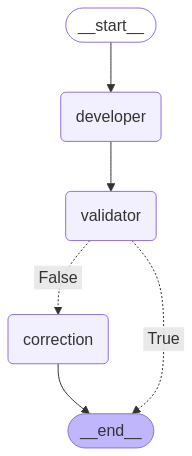

2025-03-06 01:49:04,411 - __main__ - INFO - [1357048344.py:525] - Processing tech spec for user story ID: US_141 (1/7)
2025-03-06 01:49:04,413 - __main__ - INFO - [1357048344.py:356] - Processing user story ID: US_141


developer - User Story ID: US_141


2025-03-06 01:49:29,844 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:49:29,846 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_141/attempt_initial/code.py


validate - User Story ID: US_141


2025-03-06 01:49:30,283 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:49:30,283 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 36.000000 seconds
2025-03-06 01:50:17,324 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:50:17,325 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_141/validation_results.json
2025-03-06 01:50:17,326 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_141/attempt_validated_fail/code.py


correction - User Story ID: US_141


2025-03-06 01:50:17,971 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:50:17,972 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 51.000000 seconds
2025-03-06 01:51:27,866 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:51:27,867 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_141/attempt_correction/code.py
2025-03-06 01:51:27,868 - __main__ - INFO - [1357048344.py:545] - Successfully processed tech spec for user story ID: US_141
2025-03-06 01:51:27,868 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_141/attempt_final_correcte

developer - User Story ID: US_142


2025-03-06 01:51:28,301 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:51:28,302 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 43.000000 seconds
2025-03-06 01:52:29,747 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:52:29,748 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_142/attempt_initial/code.py


validate - User Story ID: US_142


2025-03-06 01:52:30,174 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:52:30,175 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 43.000000 seconds
2025-03-06 01:53:28,043 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:53:28,045 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_142/validation_results.json
2025-03-06 01:53:28,045 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_142/attempt_validated_fail/code.py


correction - User Story ID: US_142


2025-03-06 01:53:28,687 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:53:28,688 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 46.000000 seconds
2025-03-06 01:54:34,148 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:54:34,150 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_142/attempt_correction/code.py
2025-03-06 01:54:34,151 - __main__ - INFO - [1357048344.py:545] - Successfully processed tech spec for user story ID: US_142
2025-03-06 01:54:34,151 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_142/attempt_final_correcte

developer - User Story ID: US_143


2025-03-06 01:54:34,577 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:54:34,577 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 42.000000 seconds
2025-03-06 01:55:49,683 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:55:49,685 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_143/attempt_initial/code.py


validate - User Story ID: US_143


2025-03-06 01:55:50,119 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:55:50,119 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 28.000000 seconds
2025-03-06 01:56:29,711 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:56:29,713 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_143/validation_results.json
2025-03-06 01:56:29,714 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_143/attempt_validated_fail/code.py


correction - User Story ID: US_143


2025-03-06 01:56:30,357 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:56:30,357 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 01:57:31,742 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:57:31,743 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 01:58:33,224 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:58:33,229 - __main__ - ERROR - [1357

developer - User Story ID: US_144


2025-03-06 01:58:49,820 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:58:49,851 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_144/attempt_initial/code.py


validate - User Story ID: US_144


2025-03-06 01:58:50,284 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:58:50,284 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 44.000000 seconds
2025-03-06 01:59:45,115 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 01:59:45,116 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_144/validation_results.json
2025-03-06 01:59:45,117 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_144/attempt_validated_fail/code.py


correction - User Story ID: US_144


2025-03-06 01:59:45,762 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 01:59:45,763 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 50.000000 seconds
2025-03-06 02:01:12,025 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:01:12,026 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_144/attempt_correction/code.py
2025-03-06 02:01:12,027 - __main__ - INFO - [1357048344.py:545] - Successfully processed tech spec for user story ID: US_144
2025-03-06 02:01:12,028 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_144/attempt_final_correcte

developer - User Story ID: US_145


2025-03-06 02:01:12,455 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:01:12,455 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 25.000000 seconds
2025-03-06 02:02:17,754 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:02:17,756 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_145/attempt_initial/code.py


validate - User Story ID: US_145


2025-03-06 02:02:18,194 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:02:18,194 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 21.000000 seconds
2025-03-06 02:02:50,975 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:02:50,977 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_145/validation_results.json
2025-03-06 02:02:50,977 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_145/attempt_validated_fail/code.py


correction - User Story ID: US_145


2025-03-06 02:02:51,621 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:02:51,622 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 49.000000 seconds
2025-03-06 02:04:20,131 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:04:20,132 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_145/attempt_correction/code.py
2025-03-06 02:04:20,133 - __main__ - INFO - [1357048344.py:545] - Successfully processed tech spec for user story ID: US_145
2025-03-06 02:04:20,134 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_145/attempt_final_correcte

developer - User Story ID: US_146


2025-03-06 02:04:20,577 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:04:20,578 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 22.000000 seconds
2025-03-06 02:05:02,926 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:05:02,928 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_146/attempt_initial/code.py


validate - User Story ID: US_146


2025-03-06 02:05:03,355 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:05:03,355 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 41.000000 seconds
2025-03-06 02:05:57,859 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:05:57,860 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_146/validation_results.json
2025-03-06 02:05:57,861 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_146/attempt_validated_fail/code.py


correction - User Story ID: US_146


2025-03-06 02:05:58,599 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:05:58,599 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 47.000000 seconds
2025-03-06 02:07:19,203 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:07:19,205 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_146/attempt_correction/code.py
2025-03-06 02:07:19,206 - __main__ - INFO - [1357048344.py:545] - Successfully processed tech spec for user story ID: US_146
2025-03-06 02:07:19,206 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_146/attempt_final_correcte

developer - User Story ID: US_147


2025-03-06 02:07:19,632 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:07:19,633 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 28.000000 seconds
2025-03-06 02:08:16,254 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:08:16,255 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_147/attempt_initial/code.py


validate - User Story ID: US_147


2025-03-06 02:08:16,684 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:08:16,684 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 33.000000 seconds
2025-03-06 02:09:01,327 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-06 02:09:01,329 - __main__ - INFO - [1357048344.py:428] - Saved validation results to code_generation_20250306_014903/US_147/validation_results.json
2025-03-06 02:09:01,329 - __main__ - INFO - [1357048344.py:349] - Saved code attempt to code_generation_20250306_014903/US_147/attempt_validated_fail/code.py


correction - User Story ID: US_147


2025-03-06 02:09:01,976 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:09:01,977 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 02:10:03,461 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:10:03,462 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 02:11:04,827 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 02:11:04,835 - __main__ - ERROR - [1357

All processing complete. Output directory: code_generation_20250306_014903


In [6]:
import os
import logging
import json
import re
import pandas as pd
from typing import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from IPython.display import Image, display
from datetime import datetime
import torch
from langchain_openai import AzureChatOpenAI

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Azure OpenAI configuration
os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

class CodeGenerationState(TypedDict):
    """State management for code generation process"""
    messages: Annotated[list[AnyMessage], operator.add]
    current_code: str
    validation_status: bool
    error_messages: list[str]
    is_valid: bool  # Using is_valid to match the notebook's conditional edge structure
    user_story_id: str  # Added to track user story ID for folder naming

# Define prompts
developer_prompt = """
Role: Python Developer
Task: Generate complete, production-ready Python code based on the requirements specification.

Requirements:
{requirements}

Your code must include:
1. All necessary imports and dependencies
2. Complete implementation with:
   - Well-structured classes and functions
   - Configuration management (using dataclasses or similar)
   - Comprehensive error handling and validation
   - Type hints throughout
   - Logging with appropriate levels
   - Unit tests where applicable
3. Clear documentation:
   - Module docstrings
   - Function/method docstrings with parameters and return values
   - Inline comments for complex logic

Focus on implementing EVERY aspect mentioned in the requirements. Do not leave any required functionality unimplemented.

## Output Format
Your response should be the complete, production-ready Python code without surrounding explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:

# Your Python code here
"""

validator_prompt = """
Role: Senior Code Reviewer
Task: Perform a thorough validation of the provided Python code against the requirements.

Requirements:
{Requirements}

Validation Process:
1. Carefully compare the code against EACH requirement in the specification
2. For each requirement, determine if it has been fully, partially, or not implemented
3. Identify any missing functionality, edge cases, or requirements
4. Evaluate code quality, error handling, security, and performance

Validation Checklist:
1. Code Completeness:
   - All imports and dependencies present
   - Full implementation of required functionality (check EACH requirement)
   - No placeholder code or TODOs

2. Code Quality:
   - Follows PEP 8 standards
   - Clear variable/function naming
   - Appropriate modularization
   - Avoids code duplication
   - Maintainable architecture

3. Technical Implementation:
   - Proper error handling with specific exceptions
   - Complete type annotations
   - Correct algorithm implementation
   - Efficient resource usage
   - Security considerations addressed

4. Documentation:
   - Comprehensive docstrings
   - Clear inline comments where needed

## Output Format
Return your validation report as a structured JSON object with the following format:

```json
{{
  "validation_report": {{
    "overall_assessment": "Pass/Fail",
    "issues_found": [
      "Issue 1 description",
      "Issue 2 description",
      "..."
    ],
    "suggested_improvements": [
      {{
        "description": "Improvement 1",
        "priority": "high/medium/low"
      }},
      "..."
    ],
    "implementation_vs_requirements": {{
      "match": true/false,
      "details": [
        {{
          "requirement_section": "Requirement name/section",
          "status": "Implemented/Partially Implemented/Not Implemented",
          "notes": "Notes about implementation"
        }},
        "..."
      ]
    }}
  }}
}}

Be strict in your assessment. If ANY requirement is not fully implemented, the overall assessment should be "Fail".
"""

corrector_prompt = """
Role: Senior Python Developer
Task: Refactor and fix the code based on the validation feedback.
Original Requirements:
{requirements}
Validation Feedback:
{ValidationFeedback}
Correction Instructions:

Address ALL issues identified in the validation feedback
Pay particular attention to any requirements marked as "Not Implemented" or "Partially Implemented"
Maintain the original architectural approach unless fundamentally flawed
Ensure complete implementation of ALL requirements from the original specification
Add or improve:

Error handling for all edge cases
Type hints throughout the codebase
Documentation (docstrings and comments)
Logging for important operations
Performance optimizations where possible

Important: Make sure you implement EVERY feature mentioned in the requirements that was flagged as missing or incomplete in the validation feedback.
Output Format
Your response should be the complete, corrected, production-ready Python code without explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:
Your corrected Python code here
"""

def extract_user_story_id(user_story_text):
    """
    Extract user story ID from the text that contains 'User Story ID: XXX'
    
    Args:
        user_story_text (str): The full user story text
        
    Returns:
        str: The extracted user story ID or 'unknown_id' if not found
    """
    # Look for "User Story ID: XXX" pattern
    match = re.search(r'User\s+Story\s+ID\s*:\s*(\d+)', user_story_text, re.IGNORECASE)
    if match:
        return f"US_{match.group(1)}"
    
    # Alternative pattern - look for "userstory1" or similar patterns at the start of a line
    match = re.search(r'^(?:(?:user)?story|us)(\d+)', user_story_text, re.IGNORECASE | re.MULTILINE)
    if match:
        return f"US_{match.group(1)}"
    
    # If no ID is found, generate a fallback ID based on a hash of the content
    logger.warning("No user story ID found in text, using fallback ID")
    import hashlib
    hash_id = hashlib.md5(user_story_text.encode()).hexdigest()[:8]
    return f"Unknown_ID_{hash_id}"

def read_tech_specs_from_excel(excel_file_path):
    """
    Read technical specifications from Excel file.
    
    Returns:
        List of dictionaries, each containing:
        - 'user_story_id': ID of the user story
        - 'tech_spec': Technical specification
    """
    try:
        # Read the Excel file
        df = pd.read_excel(excel_file_path)
        
        # Find the user story column and tech spec column
        user_story_col = None
        tech_spec_col = None
        
        # Determine column names - assuming first row has column headers
        col_names = df.columns.tolist()
        
        # Find user story column
        for col in col_names:
            if 'user' in str(col).lower() and 'story' in str(col).lower():
                user_story_col = col
                break
        
        # Find tech spec column
        for col in col_names:
            if ('tech' in str(col).lower() and 'spec' in str(col).lower()) or 'requirement' in str(col).lower():
                tech_spec_col = col
                break
        
        # If we didn't find the right columns, default to the first two
        if user_story_col is None and len(col_names) > 0:
            user_story_col = col_names[0]
        
        if tech_spec_col is None and len(col_names) > 1:
            tech_spec_col = col_names[1]
        
        logger.info(f"Using columns: User Story = '{user_story_col}', Tech Spec = '{tech_spec_col}'")
        
        # Extract tech specs
        tech_specs = []
        
        # Skip the first row if it's empty (which appears to be the case)
        start_row = 1 if df.iloc[0].isna().all() else 0
        
        for idx, row in df.iloc[start_row:].iterrows():
            if pd.isna(row[user_story_col]) or pd.isna(row[tech_spec_col]):
                logger.warning(f"Skipping row {idx} due to missing data")
                continue
                
            user_story_text = str(row[user_story_col])
            tech_spec_text = str(row[tech_spec_col])
            
            # Extract user story ID using the helper function
            user_story_id = extract_user_story_id(user_story_text)
            
            tech_specs.append({
                'user_story_id': user_story_id,
                'tech_spec': tech_spec_text
            })
        
        logger.info(f"Successfully extracted {len(tech_specs)} tech specs from Excel file")
        return tech_specs
        
    except Exception as e:
        logger.error(f"Error reading Excel file: {e}")
        raise

class CodeGenerator:
    """Main class for generating, validating, and correcting code"""
    
    def __init__(self, model, base_output_dir=None, system_developer="", system_validator="", system_corrector=""):
        self.system_developer = system_developer
        self.system_validator = system_validator
        self.system_corrector = system_corrector
        
        # Create output base directory
        self.base_output_dir = base_output_dir or f"code_generation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        os.makedirs(self.base_output_dir, exist_ok=True)
        
        # Initialize graph
        graph = StateGraph(CodeGenerationState)
        
        # Add nodes
        graph.add_node("developer", self.developer)
        graph.add_node("validator", self.validator)
        graph.add_node("correction", self.correction)
        
        # Add edges
        graph.add_edge("developer", "validator")
        
        # Add conditional edges (matching notebook pattern)
        graph.add_conditional_edges(
            "validator", 
            lambda state: state["is_valid"],
            {
                True: END,
                False: "correction"
            }
        )
        
        graph.add_edge("correction", END)
        
        # Set entry point
        graph.set_entry_point("developer")
        self.graph = graph.compile()
        self.model = model
        
        # Try to display graph visualization if possible
        try:
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception as e:
            logger.error(f"Error displaying graph: {e}")
            pass

    def get_output_dir(self, user_story_id):
        """Create and return a user story specific output directory"""
        # Create user story specific directory if it doesn't exist
        user_story_dir = os.path.join(self.base_output_dir, user_story_id)
        os.makedirs(user_story_dir, exist_ok=True)
        return user_story_dir

    def extract_code(self, text):
        """Extract code from between triple backticks or triple single quotes"""
        pattern = r"```(?:python)?\\s*(.*?)```"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        # Try with triple single quotes
        pattern = r"'''(?:python)?\\s*(.*?)'''"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        return text  # Return original if no code blocks found

    def save_code_attempt(self, code: str, user_story_id: str, status: str = "initial") -> str:
        """Save code attempt and return directory path"""
        # Get user story specific output directory
        output_dir = self.get_output_dir(user_story_id)
        
        attempt_dir = os.path.join(output_dir, f"attempt_{status}")
        os.makedirs(attempt_dir, exist_ok=True)
        
        # Save code
        code_file = os.path.join(attempt_dir, "code.py")
        with open(code_file, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved code attempt to {code_file}")
        return attempt_dir

    def developer(self, state: CodeGenerationState):
        """Generate initial code"""
        messages = state['messages']
        user_story_id = state.get('user_story_id', 'default_id')
        logger.info(f"Processing user story ID: {user_story_id}")
        print(f"developer - User Story ID: {user_story_id}")
        
        if self.system_developer:
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_developer.format(
                requirements=messages[0].content,  # Changed from Requirements to requirements
                TechnicalSpecifications=messages[0].content
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        
        # Extract code from response
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save code
        self.save_code_attempt(code_only, user_story_id)
        
        return {
            'messages': [message],
            'current_code': code_only,
            'validation_status': None,
            'error_messages': [],
            'is_valid': False,
            'user_story_id': user_story_id
        }

    def validator(self, state: CodeGenerationState):
        """Validate generated code"""
        messages = state.get('messages', [])
        current_code = state.get('current_code', '')
        user_story_id = state.get('user_story_id', 'default_id')
        
        print(f"validate - User Story ID: {user_story_id}")
        
        if self.system_validator:
            original_message = state["messages"][0].content if state["messages"] else ""
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_validator.format(
                Requirements=original_message,
                TechnicalSpecifications=original_message
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "").lower()
        
        # Attempt to determine if validation passed by extracting JSON
        is_valid = False
        try:
            # Try to extract JSON from the message
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                is_valid = (validation_json.get("validation_report", {}).get("overall_assessment", "").lower() == "pass")
        except:
            # Fallback to the original logic if JSON extraction fails
            is_valid = "pass" in response_text and "correctly implements" in response_text
        
        # Save validation results to JSON if possible
        try:
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                output_dir = self.get_output_dir(user_story_id)
                json_path = os.path.join(output_dir, "validation_results.json")
                with open(json_path, 'w') as f:
                    json.dump(validation_json, f, indent=2)
                logger.info(f"Saved validation results to {json_path}")
        except Exception as e:
            logger.error(f"Failed to save validation results: {e}")
        
        if is_valid:
            self.save_code_attempt(current_code, user_story_id, "validated_pass")
        else:
            self.save_code_attempt(current_code, user_story_id, "validated_fail")
            
        return {
            'messages': [message],
            'current_code': current_code,
            'is_valid': is_valid,
            'error_messages': [] if is_valid else ["Validation failed"],
            'user_story_id': user_story_id
        }

    def correction(self, state: CodeGenerationState):
        """Correct code based on validation feedback"""
        messages = state['messages']
        user_story_id = state.get('user_story_id', 'default_id')
        
        print(f"correction - User Story ID: {user_story_id}")
        
        if self.system_corrector:
            # Get original requirements from the first human message in the chain
            original_requirements = ""
            for msg in state['messages']:
                if isinstance(msg, HumanMessage) and msg.content:
                    original_requirements = msg.content
                    break
            
            # Get validation feedback from the most recent message
            validation_feedback = messages[0].content if messages else ""
            
            # Note: Using exact case from the prompt template
            formatted_prompt = self.system_corrector.format(
                requirements=original_requirements,  # Changed from Requirements to requirements
                ValidationFeedback=validation_feedback
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save corrected code
        self.save_code_attempt(code_only, user_story_id, "correction")
        
        return {
            'messages': [message],
            'current_code': code_only,
            'is_valid': False,
            'error_messages': [],
            'user_story_id': user_story_id
        }

def process_tech_specs(excel_file_path="tech.xlsx"):
    """
    Process tech specs from an Excel file
    
    Args:
        excel_file_path: Path to Excel file with tech specs
    """
    try:
        # Read tech specs from Excel
        tech_specs = read_tech_specs_from_excel(excel_file_path)
        
        if not tech_specs:
            logger.error("No tech specs found in Excel file")
            return
        
        # Model initialization
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]
        )
        
        # Create a base output directory
        base_output_dir = f"code_generation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Initialize code generator with the base directory
        code_gen = CodeGenerator(
            model=model, 
            base_output_dir=base_output_dir,
            system_developer=developer_prompt,
            system_validator=validator_prompt,
            system_corrector=corrector_prompt
        )
        
        # Process each tech spec
        for idx, spec in enumerate(tech_specs):
            user_story_id = spec['user_story_id']
            tech_spec = spec['tech_spec']
            
            logger.info(f"Processing tech spec for user story ID: {user_story_id} ({idx+1}/{len(tech_specs)})")
            
            # Setup initial message
            messages = [HumanMessage(content=tech_spec)]
            
            # Set up the input state
            initial_state = {
                "messages": messages,
                "current_code": "",
                "validation_status": None,
                "error_messages": [],
                "is_valid": False,
                "user_story_id": user_story_id
            }
            
            try:
                # Run the graph
                result = code_gen.graph.invoke(initial_state)
                
                # Log success
                logger.info(f"Successfully processed tech spec for user story ID: {user_story_id}")
                
                # Extract final code
                if 'current_code' in result and result['current_code']:
                    final_status = "final_corrected" if not result.get('is_valid', False) else "final_validated"
                    code_gen.save_code_attempt(result['current_code'], user_story_id, final_status)
            
            except Exception as e:
                logger.error(f"Error processing tech spec for user story ID {user_story_id}: {e}")
                continue
            
        logger.info(f"Completed processing all tech specs. Output directory: {base_output_dir}")
        return base_output_dir
        
    except Exception as e:
        logger.error(f"Error in process_tech_specs: {e}")
        raise

# Main execution
if __name__ == "__main__":
    output_dir = process_tech_specs("tech.xlsx")
    print(f"All processing complete. Output directory: {output_dir}")

In [2]:
"""
Code Combiner Agent

This script finds the latest code_generation folder, extracts the corrected code from each
user story subfolder, and combines them into a single cohesive Python file.
"""

import os
import logging
import re
from datetime import datetime
from collections import defaultdict

def find_latest_code_generation_folder():
    """Find the latest code_generation folder based on creation time."""
    base_dir = os.getcwd()  # Current working directory
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_corrected_code_files(base_folder):
    """
    Find all corrected code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logging.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logging.warning(f"No code files found at all for {user_folder}")
    
    return code_files

class CodeSection:
    """Base class for code sections."""
    def __init__(self, content, module_name):
        self.content = content
        self.module_name = module_name
    
    def __str__(self):
        return f"# From {self.module_name}\n{self.content}"

class ImportSection(CodeSection):
    """Section for import statements."""
    pass

class ClassSection(CodeSection):
    """Section for class definitions."""
    def __init__(self, name, content, module_name):
        super().__init__(content, module_name)
        self.name = name

class FunctionSection(CodeSection):
    """Section for function definitions."""
    def __init__(self, name, content, module_name):
        super().__init__(content, module_name)
        self.name = name

class VariableSection(CodeSection):
    """Section for global variable definitions."""
    def __init__(self, name, content, module_name):
        super().__init__(content, module_name)
        self.name = name

class OtherSection(CodeSection):
    """Section for other code."""
    pass

class CodeAnalyzer:
    """Analyzes Python code files to extract components."""
    
    def __init__(self):
        self.imports = []
        self.classes = []
        self.functions = []
        self.variables = []
        self.other_code = []

    def analyze_file(self, file_path, module_name):
        """Analyze a Python file and extract its components."""
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Split the file into lines for processing
        lines = content.splitlines()
        
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            
            # Skip empty lines
            if not line:
                i += 1
                continue
            
            # Import statements
            if line.startswith('import ') or line.startswith('from '):
                self.imports.append(ImportSection(line, module_name))
                i += 1
                continue
            
            # Class definitions
            if line.startswith('class '):
                class_name = line.split('class ')[1].split('(')[0].strip().split(':')[0].strip()
                class_lines = [lines[i]]
                i += 1
                
                # Get indentation level of the class body
                indent_level = None
                while i < len(lines):
                    if lines[i].strip():  # Non-empty line
                        current_indent = len(lines[i]) - len(lines[i].lstrip())
                        if indent_level is None:
                            indent_level = current_indent
                            if indent_level == 0:  # No indentation means we're out of the class
                                break
                        elif current_indent < indent_level:  # We've gone back to a lower indentation
                            break
                    
                    class_lines.append(lines[i])
                    i += 1
                
                self.classes.append(ClassSection(class_name, '\n'.join(class_lines), module_name))
                continue
            
            # Function definitions
            if line.startswith('def '):
                function_name = line.split('def ')[1].split('(')[0].strip()
                function_lines = [lines[i]]
                i += 1
                
                # Get indentation level of the function body
                indent_level = None
                while i < len(lines):
                    if lines[i].strip():  # Non-empty line
                        current_indent = len(lines[i]) - len(lines[i].lstrip())
                        if indent_level is None:
                            indent_level = current_indent
                            if indent_level == 0:  # No indentation means we're out of the function
                                break
                        elif current_indent < indent_level:  # We've gone back to a lower indentation
                            break
                    
                    function_lines.append(lines[i])
                    i += 1
                
                self.functions.append(FunctionSection(function_name, '\n'.join(function_lines), module_name))
                continue
            
            # Global variable assignments
            var_match = re.match(r'^([a-zA-Z_][a-zA-Z0-9_]*)\s*=', line)
            if var_match and not line.startswith(' ') and not line.startswith('\t'):
                var_name = var_match.group(1)
                self.variables.append(VariableSection(var_name, line, module_name))
                i += 1
                continue
            
            # Other code
            if not (line.startswith(' ') or line.startswith('\t')):
                # Check if it's an if __name__ == "__main__" block
                if line.startswith('if __name__ == ') and ('"__main__"' in line or "'__main__'" in line):
                    # Skip the whole block
                    i += 1
                    indent_level = None
                    while i < len(lines):
                        if lines[i].strip():  # Non-empty line
                            current_indent = len(lines[i]) - len(lines[i].lstrip())
                            if indent_level is None:
                                indent_level = current_indent
                                if indent_level == 0:  # No indentation means we're out of the block
                                    break
                            elif current_indent < indent_level:  # We've gone back to a lower indentation
                                break
                        i += 1
                    continue
                
                self.other_code.append(OtherSection(line, module_name))
                i += 1
                continue
            
            # If we get here, just move to the next line
            i += 1

class CodeCombiner:
    """Combines analyzed code sections into a single file."""
    
    def __init__(self):
        self.analyzer = CodeAnalyzer()
    
    def process_files(self, code_files):
        """Process all code files and extract their components."""
        for module_name, file_path in code_files:
            try:
                self.analyzer.analyze_file(file_path, module_name)
            except Exception as e:
                logging.error(f"Error processing {file_path}: {e}")
    
    def get_combined_code(self):
        """Generate the combined code content."""
        sections = []
        
        # Add file header
        sections.append('"""')
        sections.append('Combined Solution')
        sections.append('This file was automatically generated by combining multiple code files.')
        sections.append(f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
        sections.append('"""')
        sections.append("")
        
        # Add imports
        unique_imports = set()
        import_lines = []
        for imp in self.analyzer.imports:
            if imp.content not in unique_imports:
                unique_imports.add(imp.content)
                import_lines.append(imp.content)
        
        sections.append("# Imports")
        sections.extend(sorted(import_lines))
        sections.append("")
        
        # Add global variables
        if self.analyzer.variables:
            sections.append("# Global variables")
            for var in self.analyzer.variables:
                sections.append(str(var))
            sections.append("")
        
        # Add classes
        if self.analyzer.classes:
            sections.append("# Classes")
            for cls in self.analyzer.classes:
                sections.append(str(cls))
                sections.append("")
        
        # Add functions
        if self.analyzer.functions:
            sections.append("# Functions")
            for func in self.analyzer.functions:
                sections.append(str(func))
                sections.append("")
        
        # Add other code
        if self.analyzer.other_code:
            sections.append("# Other code")
            for code in self.analyzer.other_code:
                sections.append(str(code))
            sections.append("")
        
        # Add main block
        sections.append("# Main execution")
        sections.append('if __name__ == "__main__":')
        sections.append('    # Combined execution of all modules')
        sections.append('    try:')
        sections.append('        print("Running combined solution...")')
        
        # Check if we have main functions
        main_function_names = [func.name for func in self.analyzer.functions 
                             if func.name in ('main', 'process_tech_specs')]
        if main_function_names:
            for func_name in main_function_names:
                if func_name == 'process_tech_specs':
                    sections.append(f'        {func_name}("tech.xlsx")')
                else:
                    sections.append(f'        {func_name}()')
        
        sections.append('    except Exception as e:')
        sections.append('        logging.error(f"Error running combined solution: {e}")')
        sections.append('        raise')
        
        return '\n'.join(sections)

def combine_code_agent():
    """
    Agent that combines all corrected code files from the latest code_generation folder
    into a single cohesive file that works flawlessly.
    """
    try:
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
        )
        logger = logging.getLogger(__name__)
        
        # Find the latest code_generation folder
        latest_folder = find_latest_code_generation_folder()
        logger.info(f"Found latest code generation folder: {latest_folder}")
        
        # Find all corrected code files
        code_files = find_corrected_code_files(latest_folder)
        logger.info(f"Found {len(code_files)} code files to combine")
        
        if not code_files:
            logger.error("No code files found to combine")
            return
        
        # Combine the code files
        combiner = CodeCombiner()
        combiner.process_files(code_files)
        combined_code = combiner.get_combined_code()
        
        # Write the combined code
        output_file = os.path.join(os.path.dirname(latest_folder), f"combined_solution_{datetime.now().strftime('%Y%m%d_%H%M%S')}.py")
        with open(output_file, 'w') as f:
            f.write(combined_code)
        
        logger.info(f"Successfully combined code files into: {output_file}")
        print(f"Combined solution created at: {output_file}")
        
        return output_file
    
    except Exception as e:
        logger.error(f"Error combining code files: {e}")
        raise

# If this script is run directly
if __name__ == "__main__":
    combine_code_agent()

2025-03-06 15:12:32,416 - __main__ - INFO - [234747294.py:318] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-06 15:12:32,416 - root - INFO - [234747294.py:56] - Using 'final_corrected' code for US_145
2025-03-06 15:12:32,416 - root - INFO - [234747294.py:56] - Using 'initial' code for US_147
2025-03-06 15:12:32,416 - root - INFO - [234747294.py:56] - Using 'final_corrected' code for US_146
2025-03-06 15:12:32,416 - root - INFO - [234747294.py:56] - Using 'final_corrected' code for US_141
2025-03-06 15:12:32,416 - root - INFO - [234747294.py:56] - Using 'final_corrected' code for US_142
2025-03-06 15:12:32,417 - root - INFO - [234747294.py:56] - Using 'final_corrected' code for US_144
2025-03-06 15:12:32,417 - root - INFO - [234747294.py:56] - Using 'initial' code for US_143
2025-03-06 15:12:32,417 - __main__ - INFO - [234747294.py:322] - Found 7 code files to combine
2025-03-06 15:12:32,418 - __main__ - INFO - [23474

Combined solution created at: /home/airangers/Desktop/shivani/SDLC/combined_solution_20250306_151232.py


In [3]:
"""
Intelligent Code Combiner Agent

This script finds the latest code_generation folder, analyzes the corrected code from each
user story subfolder, and intelligently combines them into a single cohesive Python file
based on code dependencies and relationships.
"""

import os
import logging
import re
import ast
import networkx as nx
from datetime import datetime
from collections import defaultdict, Counter
from typing import Dict, List, Set, Tuple, Any, Optional

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

class CodeEntity:
    """Base class for code entities (imports, classes, functions, variables)."""
    def __init__(self, name: str, source_code: str, module_name: str, line_no: int):
        self.name = name
        self.source_code = source_code
        self.module_name = module_name
        self.line_no = line_no
        self.dependencies = set()  # Names of other entities this entity depends on
        
    def __str__(self):
        return f"# From {self.module_name}\n{self.source_code}"
    
    def add_dependency(self, name: str):
        """Add a dependency to this entity."""
        if name != self.name:  # Avoid self-dependency
            self.dependencies.add(name)

class ImportEntity(CodeEntity):
    """Class for import statements."""
    def __init__(self, name: str, source_code: str, module_name: str, line_no: int):
        super().__init__(name, source_code, module_name, line_no)
        self.imported_names = set()  # Names that are imported
        
    def add_imported_name(self, name: str):
        """Add a name that is imported by this import statement."""
        self.imported_names.add(name)

class ClassEntity(CodeEntity):
    """Class for class definitions."""
    def __init__(self, name: str, source_code: str, module_name: str, line_no: int):
        super().__init__(name, source_code, module_name, line_no)
        self.methods = set()  # Method names defined in this class
        self.superclasses = set()  # Names of superclasses
        
    def add_method(self, method_name: str):
        """Add a method name to this class."""
        self.methods.add(method_name)
        
    def add_superclass(self, superclass_name: str):
        """Add a superclass name to this class."""
        self.superclasses.add(superclass_name)
        self.add_dependency(superclass_name)

class FunctionEntity(CodeEntity):
    """Class for function definitions."""
    def __init__(self, name: str, source_code: str, module_name: str, line_no: int):
        super().__init__(name, source_code, module_name, line_no)
        self.calls = set()  # Function calls made by this function
        self.parameters = set()  # Parameter names
        self.return_values = set()  # Return value expressions
        
    def add_call(self, function_name: str):
        """Add a function call made by this function."""
        self.calls.add(function_name)
        self.add_dependency(function_name)
        
    def add_parameter(self, param_name: str):
        """Add a parameter name to this function."""
        self.parameters.add(param_name)
        
    def add_return_value(self, return_expr: str):
        """Add a return value expression to this function."""
        self.return_values.add(return_expr)

class VariableEntity(CodeEntity):
    """Class for global variable definitions."""
    def __init__(self, name: str, source_code: str, module_name: str, line_no: int):
        super().__init__(name, source_code, module_name, line_no)
        self.value = None  # Value expression
        
    def set_value(self, value: str):
        """Set the value expression of this variable."""
        self.value = value

class OtherEntity(CodeEntity):
    """Class for other code snippets."""
    pass

class DependencyVisitor(ast.NodeVisitor):
    """AST visitor to extract dependencies from code."""
    
    def __init__(self, module_name: str):
        self.module_name = module_name
        self.imports = []
        self.classes = []
        self.functions = []
        self.variables = []
        self.other_code = []
        
        # Track names that are in scope
        self.defined_names = set()
        # Track the current class or function being visited
        self.current_context = None
        # Track used names to determine dependencies
        self.used_names = defaultdict(set)
        
    def visit_Import(self, node):
        """Visit an import statement."""
        for name in node.names:
            alias = name.asname or name.name
            source_code = ast.unparse(node)
            import_entity = ImportEntity(alias, source_code, self.module_name, node.lineno)
            import_entity.add_imported_name(name.name)
            self.imports.append(import_entity)
            self.defined_names.add(alias)
        self.generic_visit(node)
        
    def visit_ImportFrom(self, node):
        """Visit a from ... import ... statement."""
        source_code = ast.unparse(node)
        module_name = node.module if node.module else ""
        
        for name in node.names:
            alias = name.asname or name.name
            import_entity = ImportEntity(alias, source_code, self.module_name, node.lineno)
            import_entity.add_imported_name(f"{module_name}.{name.name}" if module_name else name.name)
            self.imports.append(import_entity)
            self.defined_names.add(alias)
        self.generic_visit(node)
        
    def visit_ClassDef(self, node):
        """Visit a class definition."""
        # Get the source code for the class
        source_code = ast.unparse(node)
        class_entity = ClassEntity(node.name, source_code, self.module_name, node.lineno)
        
        # Track superclasses
        for base in node.bases:
            if isinstance(base, ast.Name):
                class_entity.add_superclass(base.id)
                
        # Save the previous context and set the current context to this class
        prev_context = self.current_context
        self.current_context = class_entity
        
        # Visit child nodes
        self.generic_visit(node)
        
        # Restore the previous context
        self.current_context = prev_context
        
        self.classes.append(class_entity)
        self.defined_names.add(node.name)
        
    def visit_FunctionDef(self, node):
        """Visit a function definition."""
        # Get the source code for the function
        source_code = ast.unparse(node)
        function_entity = FunctionEntity(node.name, source_code, self.module_name, node.lineno)
        
        # Add function parameters
        for arg in node.args.args:
            function_entity.add_parameter(arg.arg)
            
        # Check if this is a method of a class
        if isinstance(self.current_context, ClassEntity):
            self.current_context.add_method(node.name)
            # For class methods, we don't add them to the global namespace
        else:
            self.functions.append(function_entity)
            self.defined_names.add(node.name)
            
        # Save the previous context and set the current context to this function
        prev_context = self.current_context
        self.current_context = function_entity
            
        # Visit child nodes
        self.generic_visit(node)
        
        # Restore the previous context
        self.current_context = prev_context
        
    def visit_Assign(self, node):
        """Visit an assignment statement."""
        # Only process global variable assignments
        if not isinstance(self.current_context, (ClassEntity, FunctionEntity)):
            # Get the target names
            for target in node.targets:
                if isinstance(target, ast.Name):
                    source_code = ast.unparse(node)
                    var_entity = VariableEntity(target.id, source_code, self.module_name, node.lineno)
                    self.variables.append(var_entity)
                    self.defined_names.add(target.id)
        
        # Visit child nodes to find dependencies
        self.generic_visit(node)
        
    def visit_Call(self, node):
        """Visit a function call."""
        # Extract the function being called
        if isinstance(node.func, ast.Name):
            func_name = node.func.id
            # Record the dependency in the current context
            if isinstance(self.current_context, (FunctionEntity, ClassEntity)):
                self.used_names[self.current_context.name].add(func_name)
                if isinstance(self.current_context, FunctionEntity):
                    self.current_context.add_call(func_name)
        elif isinstance(node.func, ast.Attribute):
            # Handle method calls like obj.method()
            if isinstance(node.func.value, ast.Name):
                # Record the use of the object
                if isinstance(self.current_context, (FunctionEntity, ClassEntity)):
                    self.used_names[self.current_context.name].add(node.func.value.id)
        
        # Visit child nodes
        self.generic_visit(node)
        
    def visit_Name(self, node):
        """Visit a name (variable use)."""
        # Record name usage in the current context
        if isinstance(self.current_context, (FunctionEntity, ClassEntity)):
            # Only record names that are loaded (used), not stored or deleted
            if isinstance(node.ctx, ast.Load):
                self.used_names[self.current_context.name].add(node.id)
                
        # Visit child nodes
        self.generic_visit(node)
        
    def process_dependencies(self):
        """Process the collected information to establish dependencies."""
        # Add dependencies to functions based on name usage
        for entity in self.functions:
            for used_name in self.used_names.get(entity.name, set()):
                if used_name in self.defined_names and used_name != entity.name:
                    entity.add_dependency(used_name)
                    
        # Add dependencies to classes based on name usage
        for entity in self.classes:
            for used_name in self.used_names.get(entity.name, set()):
                if used_name in self.defined_names and used_name != entity.name:
                    entity.add_dependency(used_name)


def find_latest_code_generation_folder():
    """Find the latest code_generation folder based on creation time."""
    base_dir = os.getcwd()  # Current working directory
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_code_files(base_folder):
    """
    Find all code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logger.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logger.warning(f"No code files found at all for {user_folder}")
    
    return code_files

class IntelligentCodeCombiner:
    """Intelligently analyzes and combines Python code files."""
    
    def __init__(self):
        self.all_imports = []  # List of ImportEntity objects
        self.all_classes = []  # List of ClassEntity objects
        self.all_functions = []  # List of FunctionEntity objects
        self.all_variables = []  # List of VariableEntity objects
        self.all_other = []  # List of OtherEntity objects
        
        # Maps for quick lookup
        self.entity_map = {}  # name -> entity
        
        # Dependency graph
        self.dependency_graph = nx.DiGraph()
        
    def analyze_file(self, file_path: str, module_name: str):
        """Analyze a Python file and extract its components with dependency information."""
        logger.info(f"Analyzing file: {file_path}")
        try:
            with open(file_path, 'r') as f:
                code = f.read()
            
            try:
                # Parse the AST
                tree = ast.parse(code)
                
                # Visit the AST to extract entities and dependencies
                visitor = DependencyVisitor(module_name)
                visitor.visit(tree)
                visitor.process_dependencies()
                
                # Collect the extracted entities
                self.all_imports.extend(visitor.imports)
                self.all_classes.extend(visitor.classes)
                self.all_functions.extend(visitor.functions)
                self.all_variables.extend(visitor.variables)
                
                # Update the entity map
                for entity in visitor.imports + visitor.classes + visitor.functions + visitor.variables:
                    if entity.name in self.entity_map:
                        logger.warning(f"Duplicate entity name: {entity.name} in {module_name}")
                    self.entity_map[entity.name] = entity
                
            except SyntaxError as e:
                logger.error(f"Syntax error in file {file_path}: {e}")
                # Fallback to a simpler parsing approach for files with syntax errors
                self._simple_parse_fallback(code, file_path, module_name)
        
        except Exception as e:
            logger.error(f"Error analyzing file {file_path}: {e}")
    
    def _simple_parse_fallback(self, code: str, file_path: str, module_name: str):
        """Fallback method for parsing files that have syntax errors."""
        logger.info(f"Using fallback parser for {file_path}")
        lines = code.splitlines()
        i = 0
        
        while i < len(lines):
            line = lines[i].strip()
            
            # Skip empty lines
            if not line:
                i += 1
                continue
                
            # Extract imports
            if line.startswith('import ') or line.startswith('from '):
                import_entity = ImportEntity(
                    "import_" + str(i),  # Generate a placeholder name
                    line,
                    module_name,
                    i + 1
                )
                self.all_imports.append(import_entity)
                i += 1
                continue
                
            # Extract class definitions
            if line.startswith('class '):
                class_name = line.split('class ')[1].split('(')[0].strip().split(':')[0].strip()
                # Collect all lines of the class
                class_lines = [lines[i]]
                i += 1
                
                # Get indentation level of the class body
                indent_level = None
                while i < len(lines):
                    if lines[i].strip():  # Non-empty line
                        current_indent = len(lines[i]) - len(lines[i].lstrip())
                        if indent_level is None:
                            indent_level = current_indent
                            if indent_level == 0:  # No indentation means we're out of the class
                                break
                        elif current_indent < indent_level:  # We've gone back to a lower indentation
                            break
                    
                    class_lines.append(lines[i])
                    i += 1
                
                class_entity = ClassEntity(
                    class_name,
                    '\n'.join(class_lines),
                    module_name,
                    i + 1
                )
                self.all_classes.append(class_entity)
                self.entity_map[class_name] = class_entity
                continue
                
            # Extract function definitions
            if line.startswith('def '):
                function_name = line.split('def ')[1].split('(')[0].strip()
                # Collect all lines of the function
                function_lines = [lines[i]]
                i += 1
                
                # Get indentation level of the function body
                indent_level = None
                while i < len(lines):
                    if lines[i].strip():  # Non-empty line
                        current_indent = len(lines[i]) - len(lines[i].lstrip())
                        if indent_level is None:
                            indent_level = current_indent
                            if indent_level == 0:  # No indentation means we're out of the function
                                break
                        elif current_indent < indent_level:  # We've gone back to a lower indentation
                            break
                    
                    function_lines.append(lines[i])
                    i += 1
                
                function_entity = FunctionEntity(
                    function_name,
                    '\n'.join(function_lines),
                    module_name,
                    i + 1
                )
                self.all_functions.append(function_entity)
                self.entity_map[function_name] = function_entity
                continue
                
            # Global variable assignments
            var_match = re.match(r'^([a-zA-Z_][a-zA-Z0-9_]*)\s*=', line)
            if var_match and not line.startswith(' ') and not line.startswith('\t'):
                var_name = var_match.group(1)
                var_entity = VariableEntity(
                    var_name,
                    line,
                    module_name,
                    i + 1
                )
                self.all_variables.append(var_entity)
                self.entity_map[var_name] = var_entity
                i += 1
                continue
                
            # Other code
            other_entity = OtherEntity(
                f"other_{i}",
                line,
                module_name,
                i + 1
            )
            self.all_other.append(other_entity)
            i += 1
    
    def build_dependency_graph(self):
        """Build a dependency graph from the analyzed code entities."""
        logger.info("Building dependency graph")
        
        # Add nodes to the graph
        for entity in list(self.entity_map.values()):
            self.dependency_graph.add_node(entity.name, entity=entity)
        
        # Add edges based on dependencies
        for entity in list(self.entity_map.values()):
            for dep_name in entity.dependencies:
                if dep_name in self.entity_map:
                    self.dependency_graph.add_edge(dep_name, entity.name)
        
        # Special handling for imports: they should come first
        for import_entity in self.all_imports:
            # Create a unique identifier for this import statement
            import_id = f"import_{import_entity.line_no}_{import_entity.module_name}"
            
            # Add it to the graph if not already there
            if import_id not in self.dependency_graph:
                self.dependency_graph.add_node(import_id, entity=import_entity)
            
            # Add edges from imports to any entities that might use them
            for entity_name, entity in self.entity_map.items():
                # Skip imports themselves
                if isinstance(entity, ImportEntity):
                    continue
                    
                # If the import brings in a name that's used in the entity's dependencies,
                # add an edge from the import to the entity
                for imported_name in import_entity.imported_names:
                    if imported_name in entity.dependencies:
                        self.dependency_graph.add_edge(import_id, entity_name)
    
    def sort_entities_topologically(self):
        """Sort the entities topologically based on dependencies."""
        logger.info("Sorting entities topologically")
        
        # Make sure the graph is built
        if not self.dependency_graph.nodes():
            self.build_dependency_graph()
        
        # Try to sort topologically
        try:
            sorted_names = list(nx.topological_sort(self.dependency_graph))
            # Reverse the order so that dependencies come before dependents
            sorted_names.reverse()
            
            # Create the sorted entity list
            sorted_entities = []
            for name in sorted_names:
                if name in self.dependency_graph.nodes:
                    entity = self.dependency_graph.nodes[name]['entity']
                    sorted_entities.append(entity)
            
            return sorted_entities
        except nx.NetworkXUnfeasible:
            # If there's a cycle, we can't sort topologically
            logger.warning("Dependency graph has cycles. Using a heuristic sorting approach.")
            return self._heuristic_sort()
    
    def _heuristic_sort(self):
        """Use a heuristic approach to sort entities when topological sort fails."""
        # Define a priority order for entity types
        # Imports first, then variables, classes, functions, and other code
        sorted_entities = self.all_imports + self.all_variables + self.all_classes + self.all_functions + self.all_other
        
        # Try to identify entry points (functions that are not called by others)
        entry_points = [entity for entity in self.all_functions if not any(entity.name in dep_entity.dependencies for dep_entity in self.all_functions)]
        
        # Move entry points to the end
        for entry in entry_points:
            if entry in sorted_entities:
                sorted_entities.remove(entry)
                sorted_entities.append(entry)
        
        return sorted_entities
    
    def resolve_conflicts(self):
        """Resolve naming conflicts between entities."""
        logger.info("Resolving naming conflicts")
        
        # Count occurrences of each name
        name_counts = Counter([entity.name for entity in 
                             self.all_classes + self.all_functions + self.all_variables])
        
        # Find names with multiple occurrences
        conflicts = {name: count for name, count in name_counts.items() if count > 1}
        
        for name, count in conflicts.items():
            logger.warning(f"Conflict detected: {name} appears {count} times")
            
            # Get all entities with this name
            entities = [entity for entity in 
                      self.all_classes + self.all_functions + self.all_variables 
                      if entity.name == name]
            
            # Rename all but the most complex entity (assuming more complex = more important)
            # We measure complexity by source code length as a simple heuristic
            entities.sort(key=lambda e: len(e.source_code), reverse=True)
            
            # Keep the most complex entity as is
            kept_entity = entities[0]
            
            # Rename the rest
            for i, entity in enumerate(entities[1:], 1):
                new_name = f"{name}_{entity.module_name.replace('US_', '')}"
                
                # Update the source code with the new name
                entity.source_code = entity.source_code.replace(
                    f"def {name}(", f"def {new_name}(", 1)
                entity.source_code = entity.source_code.replace(
                    f"class {name}(", f"class {new_name}(", 1)
                entity.source_code = entity.source_code.replace(
                    f"{name} =", f"{new_name} =", 1)
                
                # Update the entity name
                old_name = entity.name
                entity.name = new_name
                
                # Update the entity map
                if old_name in self.entity_map:
                    del self.entity_map[old_name]
                self.entity_map[new_name] = entity
                
                logger.info(f"Renamed {old_name} to {new_name} in {entity.module_name}")
    
    def generate_combined_code(self):
        """Generate the combined code based on the dependency analysis."""
        logger.info("Generating combined code")
        
        # Resolve naming conflicts
        self.resolve_conflicts()
        
        # Sort entities
        sorted_entities = self.sort_entities_topologically()
        
        # Prepare the output sections
        sections = []
        
        # Add file header
        sections.append('"""')
        sections.append('Intelligently Combined Solution')
        sections.append('This file was automatically generated by the Intelligent Code Combiner Agent.')
        sections.append(f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
        sections.append('"""')
        sections.append("")
        
        # Add imports (deduplicated)
        sections.append("# Imports")
        added_imports = set()
        for entity in sorted_entities:
            if isinstance(entity, ImportEntity):
                # Deduplicate imports
                if entity.source_code not in added_imports:
                    added_imports.add(entity.source_code)
                    sections.append(entity.source_code)
        sections.append("")
        
        # Add global variables
        variable_entities = [e for e in sorted_entities if isinstance(e, VariableEntity)]
        if variable_entities:
            sections.append("# Global variables")
            for entity in variable_entities:
                sections.append(f"# From {entity.module_name}")
                sections.append(entity.source_code)
            sections.append("")
        
        # Add classes
        class_entities = [e for e in sorted_entities if isinstance(e, ClassEntity)]
        if class_entities:
            sections.append("# Classes")
            for entity in class_entities:
                sections.append(f"# From {entity.module_name}")
                sections.append(entity.source_code)
                sections.append("")
        
        # Add functions
        function_entities = [e for e in sorted_entities if isinstance(e, FunctionEntity)]
        if function_entities:
            sections.append("# Functions")
            for entity in function_entities:
                sections.append(f"# From {entity.module_name}")
                sections.append(entity.source_code)
                sections.append("")
        
        # Add other code
        other_entities = [e for e in sorted_entities if isinstance(e, OtherEntity)]
        if other_entities:
            sections.append("# Other code")
            for entity in other_entities:
                if "if __name__ == '__main__'" not in entity.source_code and 'if __name__ == "__main__"' not in entity.source_code:
                    sections.append(f"# From {entity.module_name}")
                    sections.append(entity.source_code)
            sections.append("")
        
        # Identify main functions for the execution block
        main_function_candidates = [
            entity.name for entity in function_entities
            if entity.name in ('main', 'process_tech_specs', 'run', 'execute')
        ]
        
        # Add main execution block
        sections.append("# Main execution")
        sections.append('if __name__ == "__main__":')
        sections.append('    # Intelligent execution of combined solution')
        sections.append('    try:')
        sections.append('        print("Running intelligently combined solution...")')
        
        if main_function_candidates:
            for func_name in main_function_candidates:
                if func_name == 'process_tech_specs':
                    sections.append(f'        {func_name}("tech.xlsx")')
                else:
                    sections.append(f'        {func_name}()')
        else:
            # If no main functions found, look for other potential entry points
            entry_points = []
            for entity in function_entities:
                # Count how many times this function is called by others
                call_count = sum(1 for other in function_entities if entity.name in other.calls)
                if call_count == 0 and entity.name not in ('__init__', 'setup', 'configure'):
                    entry_points.append(entity.name)
            
            if entry_points:
                sections.append('        # No explicit main function found, calling potential entry points')
                for func_name in entry_points[:3]:  # Limit to top 3 potential entry points
                    sections.append(f'        # {func_name}()')
        
        sections.append('    except Exception as e:')
        sections.append('        logging.error(f"Error running combined solution: {e}")')
        sections.append('        import traceback')
        sections.append('        traceback.print_exc()')
        
        return '\n'.join(sections)

def intelligent_code_combiner_agent():
    """
    Agent that intelligently combines all code files from the latest code_generation folder
    into a single cohesive file that works flawlessly, taking into account code dependencies.
    """
    try:
        # Find the latest code_generation folder
        latest_folder = find_latest_code_generation_folder()
        logger.info(f"Found latest code generation folder: {latest_folder}")
        
        # Find all code files
        code_files = find_code_files(latest_folder)
        logger.info(f"Found {len(code_files)} code files to combine")
        
        if not code_files:
            logger.error("No code files found to combine")
            return
        
        # Initialize the intelligent code combiner
        combiner = IntelligentCodeCombiner()
        
        # Analyze each file
        for module_name, file_path in code_files:
            combiner.analyze_file(file_path, module_name)
        
        # Build the dependency graph
        combiner.build_dependency_graph()
        
        # Generate the combined code
        combined_code = combiner.generate_combined_code()
        
        # Write the combined code
        output_file = os.path.join(os.path.dirname(latest_folder), 
                                 f"intelligent_solution_{datetime.now().strftime('%Y%m%d_%H%M%S')}.py")
        with open(output_file, 'w') as f:
            f.write(combined_code)
        
        logger.info(f"Successfully created intelligent combined solution: {output_file}")
        print(f"Intelligent combined solution created at: {output_file}")
        
        return output_file
    
    except Exception as e:
        logger.error(f"Error in intelligent code combiner: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    intelligent_code_combiner_agent()

2025-03-06 15:16:21,149 - __main__ - INFO - [3095127349.py:720] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-06 15:16:21,149 - __main__ - INFO - [3095127349.py:300] - Using 'final_corrected' code for US_145
2025-03-06 15:16:21,150 - __main__ - INFO - [3095127349.py:300] - Using 'initial' code for US_147
2025-03-06 15:16:21,150 - __main__ - INFO - [3095127349.py:300] - Using 'final_corrected' code for US_146
2025-03-06 15:16:21,150 - __main__ - INFO - [3095127349.py:300] - Using 'final_corrected' code for US_141
2025-03-06 15:16:21,150 - __main__ - INFO - [3095127349.py:300] - Using 'final_corrected' code for US_142
2025-03-06 15:16:21,150 - __main__ - INFO - [3095127349.py:300] - Using 'final_corrected' code for US_144
2025-03-06 15:16:21,151 - __main__ - INFO - [3095127349.py:300] - Using 'initial' code for US_143
2025-03-06 15:16:21,151 - __main__ - INFO - [3095127349.py:724] - Found 7 code files to combine
2025-0

Intelligent combined solution created at: /home/airangers/Desktop/shivani/SDLC/intelligent_solution_20250306_151621.py


In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

In [7]:
"""
LLM-Powered Code Combiner Agent

This script uses GPT-4o via Azure OpenAI to intelligently combine code files
from the latest code generation folder into a single cohesive file.
"""

import os
import logging
import json
from datetime import datetime
from typing import List, Dict, Tuple
import textwrap
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import tiktoken

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Ensure Azure OpenAI environment variables are set
def check_openai_config():
    """Check if Azure OpenAI config is set in environment variables."""
    required_vars = [
        "AZURE_OPENAI_API_KEY",
        "AZURE_OPENAI_ENDPOINT",
        "AZURE_OPENAI_API_VERSION",
        "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"
    ]
    
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        # Try to read from the existing code
        try:
            with open(__file__, 'r') as f:
                content = f.read()
                for var in missing:
                    import re
                    match = re.search(rf'os\.environ\["{var}"\]\s*=\s*"([^"]+)"', content)
                    if match:
                        os.environ[var] = match.group(1)
                        logger.info(f"Set {var} from source code")
        except Exception as e:
            logger.warning(f"Could not read OpenAI config from source: {e}")
    
    # Verify all variables are set
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        raise EnvironmentError(f"Missing Azure OpenAI configuration: {', '.join(missing)}")
    
    logger.info("Azure OpenAI configuration verified")

def find_latest_code_generation_folder():
    """Find the latest code_generation folder based on creation time."""
    base_dir = os.getcwd()  # Current working directory
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_code_files(base_folder):
    """
    Find all code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logger.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logger.warning(f"No code files found at all for {user_folder}")
    
    return code_files

def read_code_files(code_files):
    """Read code files and return a dictionary mapping module names to code content."""
    code_contents = {}
    
    for module_name, file_path in code_files:
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                code_contents[module_name] = content
                logger.info(f"Read {len(content)} bytes from {file_path}")
        except Exception as e:
            logger.error(f"Error reading {file_path}: {e}")
    
    return code_contents

def count_tokens(text: str) -> int:
    """Count the number of tokens in a text string."""
    try:
        encoder = tiktoken.encoding_for_model("gpt-4o-2024-05-13")
        return len(encoder.encode(text))
    except:
        # Fallback to a rough approximation if tiktoken is not available
        return len(text) // 4

def chunk_code_for_llm(code_contents: Dict[str, str], max_tokens: int = 120000):
    """
    Chunk code contents to fit within token limits.
    Returns a list of chunks, where each chunk is a dictionary of module names to code contents.
    """
    chunks = []
    current_chunk = {}
    current_tokens = 0
    
    # Sort by size to try to pack more efficiently
    modules = sorted(code_contents.items(), key=lambda x: len(x[1]))
    
    for module_name, content in modules:
        # Count tokens for this module
        module_tokens = count_tokens(f"Module {module_name}:\n{content}")
        
        # If adding this module would exceed the limit, start a new chunk
        if current_tokens + module_tokens > max_tokens and current_chunk:
            chunks.append(current_chunk)
            current_chunk = {}
            current_tokens = 0
        
        # Add module to current chunk
        current_chunk[module_name] = content
        current_tokens += module_tokens
    
    # Add the last chunk if it's not empty
    if current_chunk:
        chunks.append(current_chunk)
    
    logger.info(f"Split code into {len(chunks)} chunks for processing")
    return chunks

def prepare_prompt_for_llm(code_chunk: Dict[str, str]) -> str:
    """Prepare a prompt for the LLM to combine code."""
    modules_text = []
    
    for module_name, content in code_chunk.items():
        modules_text.append(f"MODULE: {module_name}\n```python\n{content}\n```\n")
    
    prompt = f"""
I have multiple Python modules that were generated separately but need to be combined into a single cohesive file.
Please analyze these modules and combine them intelligently, considering dependencies and avoiding duplication.

Here are the modules:

{"".join(modules_text)}

Please combine these modules into a single Python file, making sure to:
1. Arrange code in the correct order (imports first, then classes, functions, and main execution)
2. Remove duplicate imports, functions, or classes
3. Resolve any naming conflicts
4. Maintain all functionality from the original modules
5. Ensure dependencies between components are preserved
6. Include a main execution block that calls the appropriate entry points
7. Make the combined code as clean and readable as possible
8. Add helpful comments to explain the combined structure

Return only the final combined Python code without explanation or other text.
"""
    return prompt

def analyze_and_combine_with_llm(model, code_chunks: List[Dict[str, str]]) -> str:
    """Use the LLM to analyze and combine code chunks."""
    if len(code_chunks) == 1:
        # If there's only one chunk, process it directly
        prompt = prepare_prompt_for_llm(code_chunks[0])
        system_message = SystemMessage(content="You are a Python expert who specializes in analyzing and combining code modules.")
        human_message = HumanMessage(content=prompt)
        
        response = model.invoke([system_message, human_message])
        combined_code = response.content
        
        return combined_code
    else:
        # If there are multiple chunks, process them iteratively
        intermediate_results = []
        
        # First pass: process each chunk separately
        for i, chunk in enumerate(code_chunks):
            logger.info(f"Processing chunk {i+1}/{len(code_chunks)}")
            prompt = prepare_prompt_for_llm(chunk)
            system_message = SystemMessage(content="You are a Python expert who specializes in analyzing and combining code modules.")
            human_message = HumanMessage(content=prompt)
            
            response = model.invoke([system_message, human_message])
            intermediate_results.append(response.content)
        
        # Second pass: combine the intermediate results
        final_modules = {f"Combined_Chunk_{i}": code for i, code in enumerate(intermediate_results)}
        final_prompt = prepare_prompt_for_llm(final_modules)
        
        system_message = SystemMessage(content="You are a Python expert who specializes in analyzing and combining code modules.")
        human_message = HumanMessage(content=final_prompt)
        
        response = model.invoke([system_message, human_message])
        combined_code = response.content
        
        return combined_code

def extract_code_from_llm_response(response: str) -> str:
    """Extract code from LLM response, removing any markdown code blocks."""
    # Check if the response is wrapped in code blocks
    if response.startswith("```python") and response.endswith("```"):
        # Extract code between the markers
        code = response.split("```python", 1)[1].rsplit("```", 1)[0].strip()
        return code
    elif response.startswith("```") and response.endswith("```"):
        # Extract code between the markers
        code = response.split("```", 2)[1]
        if code.startswith("python"):
            code = code[6:]
        return code.strip()
    
    # If not wrapped in code blocks, return as is
    return response

def llm_code_combiner_agent():
    """
    Agent that uses LLM to intelligently combine all code files from the latest 
    code_generation folder into a single cohesive file.
    """
    try:
        # Check Azure OpenAI configuration
        check_openai_config()
        
        # Initialize the model
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
            temperature=0.2  # Lower temperature for more deterministic code combination
        )
        
        # Find the latest code_generation folder
        latest_folder = find_latest_code_generation_folder()
        logger.info(f"Found latest code generation folder: {latest_folder}")
        
        # Find all code files
        code_files = find_code_files(latest_folder)
        logger.info(f"Found {len(code_files)} code files to combine")
        
        if not code_files:
            logger.error("No code files found to combine")
            return
        
        # Read all code files
        code_contents = read_code_files(code_files)
        
        # Chunk code for processing by the LLM
        code_chunks = chunk_code_for_llm(code_contents)
        
        # Use the LLM to analyze and combine the code
        logger.info("Using LLM to analyze and combine code")
        combined_code = analyze_and_combine_with_llm(model, code_chunks)
        
        # Extract code from LLM response if needed
        combined_code = extract_code_from_llm_response(combined_code)
        
        # Add a header comment
        header = f'''"""
LLM-Combined Solution
This file was automatically generated by the LLM Code Combiner Agent.
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

'''
        combined_code = header + combined_code
        
        # Write the combined code
        output_file = os.path.join(os.path.dirname(latest_folder), 
                                 f"llm_combined_solution_{datetime.now().strftime('%Y%m%d_%H%M%S')}.py")
        with open(output_file, 'w') as f:
            f.write(combined_code)
        
        logger.info(f"Successfully created LLM-combined solution: {output_file}")
        print(f"LLM-combined solution created at: {output_file}")
        
        return output_file
    
    except Exception as e:
        logger.error(f"Error in LLM code combiner: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    llm_code_combiner_agent()

2025-03-06 15:25:49,182 - __main__ - INFO - [1217235215.py:55] - Azure OpenAI configuration verified
2025-03-06 15:25:49,188 - __main__ - INFO - [1217235215.py:268] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'final_corrected' code for US_145
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'initial' code for US_147
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'final_corrected' code for US_146
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'final_corrected' code for US_141
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'final_corrected' code for US_142
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'final_corrected' code for US_144
2025-03-06 15:25:49,189 - __main__ - INFO - [1217235215.py:99] - Using 'initial' code for US_143
2025-03-

2025-03-06 15:25:50,658 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 15:25:50,659 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 15:26:52,306 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 15:26:52,306 - openai._base_client - INFO - [_base_client.py:1092] - Retrying request to /chat/completions in 60.000000 seconds
2025-03-06 15:27:53,776 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-06 15:27:53,778 - __main__ - ERROR - [1217

RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-08-01-preview have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 60 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}

In [1]:
"""
API Documentation-Based Code Integrator

This script generates API documentation for code modules and uses that documentation
to guide the LLM in creating an integrated solution.
"""

import os
import ast
import re
import logging
import json
from datetime import datetime
from typing import List, Dict, Tuple, Optional, Set
import textwrap

from langchain_openai import AzureChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Ensure Azure OpenAI environment variables are set
def check_openai_config():
    """Check if Azure OpenAI config is set in environment variables."""
    required_vars = [
        "AZURE_OPENAI_API_KEY",
        "AZURE_OPENAI_ENDPOINT",
        "AZURE_OPENAI_API_VERSION",
        "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"
    ]
    
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        # Check if we can find them in the current file
        logger.info("Looking for OpenAI configuration in current environment...")
        
        # Try to use values that might be in the environment from previous execution
        if "AZURE_OPENAI_API_KEY" not in os.environ and '0bf3daeba1814d03b5d62e1da4077478' not in os.environ.values():
            os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
        
        if "AZURE_OPENAI_ENDPOINT" not in os.environ and 'https://openaisk123.openai.azure.com/' not in os.environ.values():
            os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
        
        if "AZURE_OPENAI_API_VERSION" not in os.environ and '2024-08-01-preview' not in os.environ.values():
            os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
        
        if "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME" not in os.environ and 'gpt-4o' not in os.environ.values():
            os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"
    
    # Verify all variables are set
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        raise EnvironmentError(f"Missing Azure OpenAI configuration: {', '.join(missing)}")
    
    logger.info("Azure OpenAI configuration verified")

def find_latest_code_generation_folder():
    """Find the latest code_generation folder based on creation time."""
    base_dir = os.getcwd()  # Current working directory
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_code_files(base_folder):
    """
    Find all code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logger.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logger.warning(f"No code files found at all for {user_folder}")
    
    return code_files

def read_code_files(code_files):
    """Read code files and return a dictionary mapping module names to code content."""
    code_contents = {}
    
    for module_name, file_path in code_files:
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                code_contents[module_name] = content
                logger.info(f"Read {len(content)} bytes from {file_path}")
        except Exception as e:
            logger.error(f"Error reading {file_path}: {e}")
    
    return code_contents

class APIDocGenerator:
    """Class to generate API documentation for Python code."""
    
    def __init__(self, model):
        self.model = model
    
    def extract_docstring(self, node):
        """Extract docstring from an AST node."""
        if isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.Module)):
            if (node.body and isinstance(node.body[0], ast.Expr) and 
                isinstance(node.body[0].value, ast.Str)):
                return node.body[0].value.s.strip()
        return None
    
    def extract_function_info(self, func_node):
        """Extract information about a function from its AST node."""
        name = func_node.name
        docstring = self.extract_docstring(func_node) or "No documentation available."
        
        params = []
        returns = None
        
        # Extract parameters
        for arg in func_node.args.args:
            param_name = arg.arg
            param_type = None
            
            # Check for type annotation
            if arg.annotation:
                param_type = ast.unparse(arg.annotation)
            
            params.append({
                "name": param_name,
                "type": param_type,
                "description": "Parameter description not available."
            })
        
        # Extract return type from annotation if available
        if func_node.returns:
            returns = ast.unparse(func_node.returns)
        
        # Look for parameter and return descriptions in docstring
        if docstring:
            # Parse parameters from docstring
            param_matches = re.findall(r'(?:Args|Parameters):\s*(.*?)(?:\n\n|\Z)', docstring, re.DOTALL)
            if param_matches:
                param_section = param_matches[0]
                param_descriptions = re.findall(r'(\w+)(?:\s+\((.*?)\))?\s*:\s*(.*?)(?=\n\s*\w+\s*:|$)', param_section, re.DOTALL)
                
                for param_name, param_type, param_desc in param_descriptions:
                    for param in params:
                        if param["name"] == param_name:
                            param["description"] = param_desc.strip()
                            if not param["type"] and param_type:
                                param["type"] = param_type
            
            # Parse return from docstring
            returns_matches = re.findall(r'(?:Returns|Return):\s*(.*?)(?:\n\n|\Z)', docstring, re.DOTALL)
            if returns_matches and not returns:
                return_section = returns_matches[0].strip()
                # Check if there's a type specified
                return_type_match = re.match(r'(?:.*?)\s*\((.*?)\)\s*:', return_section)
                if return_type_match:
                    returns = return_type_match.group(1)
        
        return {
            "name": name,
            "docstring": docstring,
            "parameters": params,
            "returns": returns
        }
    
    def extract_class_info(self, class_node):
        """Extract information about a class from its AST node."""
        name = class_node.name
        docstring = self.extract_docstring(class_node) or "No documentation available."
        
        # Get base classes
        bases = []
        for base in class_node.bases:
            if isinstance(base, ast.Name):
                bases.append(base.id)
            else:
                bases.append(ast.unparse(base))
        
        # Get methods
        methods = []
        for node in class_node.body:
            if isinstance(node, ast.FunctionDef):
                methods.append(self.extract_function_info(node))
        
        return {
            "name": name,
            "docstring": docstring,
            "bases": bases,
            "methods": methods
        }
    
    def extract_global_vars(self, module_node):
        """Extract global variables from a module."""
        variables = []
        
        for node in module_node.body:
            if isinstance(node, ast.Assign) and isinstance(node.targets[0], ast.Name):
                var_name = node.targets[0].id
                var_value = ast.unparse(node.value)
                variables.append({
                    "name": var_name,
                    "value": var_value
                })
                
        return variables
    
    def extract_imports(self, module_node):
        """Extract imports from a module."""
        imports = []
        
        for node in module_node.body:
            if isinstance(node, ast.Import):
                for name in node.names:
                    imports.append({
                        "module": name.name,
                        "alias": name.asname
                    })
            elif isinstance(node, ast.ImportFrom):
                module = node.module or ""
                for name in node.names:
                    imports.append({
                        "module": module,
                        "name": name.name,
                        "alias": name.asname
                    })
                    
        return imports
    
    def generate_module_api_doc(self, module_name, code):
        """Generate API documentation for a module."""
        try:
            tree = ast.parse(code)
            
            module_doc = {
                "name": module_name,
                "docstring": self.extract_docstring(tree) or "No module documentation available.",
                "imports": self.extract_imports(tree),
                "global_vars": self.extract_global_vars(tree),
                "functions": [],
                "classes": []
            }
            
            # Extract functions and classes
            for node in tree.body:
                if isinstance(node, ast.FunctionDef):
                    module_doc["functions"].append(self.extract_function_info(node))
                elif isinstance(node, ast.ClassDef):
                    module_doc["classes"].append(self.extract_class_info(node))
            
            return module_doc
            
        except SyntaxError as e:
            logger.error(f"Syntax error in module {module_name}: {e}")
            return self._fallback_api_doc_generation(module_name, code)
    
    def _fallback_api_doc_generation(self, module_name, code):
        """Use the LLM as a fallback for API doc generation when parsing fails."""
        logger.info(f"Using LLM to extract API documentation for {module_name}")
        
        prompt = f"""
Generate a detailed API documentation for the following Python code module.
Extract all functions, classes, methods, and their parameters, return types, and docstrings.
Format the response as a JSON object with the structure shown in the example.

Example structure:
```json
{{
  "name": "module_name",
  "docstring": "Module docstring",
  "imports": [
    {{"module": "os", "alias": null}},
    {{"module": "pandas", "alias": "pd"}}
  ],
  "global_vars": [
    {{"name": "logger", "value": "logging.getLogger(__name__)"}}
  ],
  "functions": [
    {{
      "name": "function_name",
      "docstring": "Function docstring",
      "parameters": [
        {{"name": "param1", "type": "str", "description": "Description of param1"}}
      ],
      "returns": "str"
    }}
  ],
  "classes": [
    {{
      "name": "ClassName",
      "docstring": "Class docstring",
      "bases": ["BaseClass"],
      "methods": [
        {{
          "name": "method_name",
          "docstring": "Method docstring",
          "parameters": [
            {{"name": "self", "type": null, "description": "Instance reference"}},
            {{"name": "param1", "type": "str", "description": "Description of param1"}}
          ],
          "returns": "bool"
        }}
      ]
    }}
  ]
}}
```

Here's the code to document:

```python
{code}
```

Extract as much detail as possible. If you can't determine something exactly (like a type), make your best guess based on context.
"""

        system_message = SystemMessage(content="You are a Python expert who specializes in extracting API documentation from code.")
        human_message = HumanMessage(content=prompt)
        
        try:
            response = self.model.invoke([system_message, human_message])
            content = response.content
            
            # Try to extract JSON from the response
            json_match = re.search(r'```json\s*(.*?)\s*```', content, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # If no JSON code block, try to find any JSON object
                json_match = re.search(r'({[\s\S]*})', content)
                if json_match:
                    json_str = json_match.group(1)
                else:
                    json_str = content
            
            return json.loads(json_str)
        
        except Exception as e:
            logger.error(f"Error getting API doc from LLM for {module_name}: {e}")
            # Return a minimal structure
            return {
                "name": module_name,
                "docstring": "Documentation extraction failed.",
                "imports": [],
                "global_vars": [],
                "functions": [],
                "classes": []
            }
    
    def generate_all_module_docs(self, code_contents):
        """Generate API documentation for all modules."""
        module_docs = {}
        
        for module_name, code in code_contents.items():
            try:
                module_doc = self.generate_module_api_doc(module_name, code)
                module_docs[module_name] = module_doc
                logger.info(f"Generated API documentation for {module_name}")
            except Exception as e:
                logger.error(f"Error generating API doc for {module_name}: {e}")
        
        return module_docs
    
    def format_api_docs_for_llm(self, module_docs):
        """Format API documentation for use in LLM prompt."""
        formatted_docs = []
        
        for module_name, doc in module_docs.items():
            module_text = [f"MODULE: {module_name}"]
            
            # Add module docstring
            module_text.append(f"Description: {doc['docstring']}")
            module_text.append("")
            
            # Add imports
            if doc["imports"]:
                module_text.append("Imports:")
                for imp in doc["imports"]:
                    if "name" in imp:
                        from_txt = f"from {imp['module']} " if imp['module'] else "from "
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  {from_txt}import {imp['name']}{as_txt}")
                    else:
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  import {imp['module']}{as_txt}")
                module_text.append("")
            
            # Add global variables
            if doc["global_vars"]:
                module_text.append("Global Variables:")
                for var in doc["global_vars"]:
                    module_text.append(f"  {var['name']} = {var['value']}")
                module_text.append("")
            
            # Add classes
            if doc["classes"]:
                module_text.append("Classes:")
                for cls in doc["classes"]:
                    bases = f"({', '.join(cls['bases'])})" if cls['bases'] else ""
                    module_text.append(f"  class {cls['name']}{bases}:")
                    module_text.append(f"    \"{cls['docstring']}\"")
                    module_text.append("")
                    
                    if cls["methods"]:
                        module_text.append("    Methods:")
                        for method in cls["methods"]:
                            params = []
                            for p in method["parameters"]:
                                param_type = f": {p['type']}" if p['type'] else ""
                                params.append(f"{p['name']}{param_type}")
                            
                            returns = f" -> {method['returns']}" if method['returns'] else ""
                            module_text.append(f"      def {method['name']}({', '.join(params)}){returns}:")
                            module_text.append(f"        \"{method['docstring']}\"")
                            
                            # Add parameter descriptions
                            if any(p["description"] != "Parameter description not available." for p in method["parameters"]):
                                module_text.append("        Parameters:")
                                for p in method["parameters"]:
                                    if p["description"] != "Parameter description not available.":
                                        module_text.append(f"          {p['name']}: {p['description']}")
                            
                            module_text.append("")
                    
                    module_text.append("")
            
            # Add functions
            if doc["functions"]:
                module_text.append("Functions:")
                for func in doc["functions"]:
                    params = []
                    for p in func["parameters"]:
                        param_type = f": {p['type']}" if p['type'] else ""
                        params.append(f"{p['name']}{param_type}")
                    
                    returns = f" -> {func['returns']}" if func['returns'] else ""
                    module_text.append(f"  def {func['name']}({', '.join(params)}){returns}:")
                    module_text.append(f"    \"{func['docstring']}\"")
                    
                    # Add parameter descriptions
                    if any(p["description"] != "Parameter description not available." for p in func["parameters"]):
                        module_text.append("    Parameters:")
                        for p in func["parameters"]:
                            if p["description"] != "Parameter description not available.":
                                module_text.append(f"      {p['name']}: {p['description']}")
                    
                    module_text.append("")
            
            formatted_docs.append("\n".join(module_text))
        
        return "\n\n" + "\n\n".join(formatted_docs) + "\n"

class CodeIntegrator:
    """Class to integrate code modules based on API documentation."""
    
    def __init__(self, model, doc_generator):
        self.model = model
        self.doc_generator = doc_generator
    
    def create_integration_prompt(self, api_docs):
        """Create a prompt for the LLM to integrate the code."""
        prompt = f"""
I have multiple Python modules that need to be integrated into a cohesive solution.
Below is the API documentation for each module.

{api_docs}

Your task is to:

1. Create a single integrated Python file that can use ALL these modules
2. Design the integrated solution to call the appropriate functions from each module
3. Ensure proper sequencing and dependencies between modules
4. Maintain all original functionality while avoiding code duplication
5. Include a main execution block that coordinates the overall flow
6. Use proper imports and references to make the solution work seamlessly
7. Write clear comments to explain how the integration works

The solution should act as a coordinator that calls functions from the modules above
rather than reimplementing the functionality. Assume each module will be available
as a separate file that can be imported.

Format your response as a single Python file with all necessary imports, functions, 
and a main execution block. Add helpful comments to explain your integration strategy.

Return only the final integrated Python code without explanation or other text.
"""
        return prompt
    
    def generate_integrated_code(self, module_docs):
        """Generate integrated code based on API documentation."""
        # Format API docs for the LLM
        api_docs_text = self.doc_generator.format_api_docs_for_llm(module_docs)
        
        # Create the prompt
        prompt = self.create_integration_prompt(api_docs_text)
        
        # Send to LLM
        system_message = SystemMessage(content="""You are a Python expert who specializes in integrating multiple code modules 
into cohesive solutions. You excel at understanding module dependencies and creating orchestration code.""")
        human_message = HumanMessage(content=prompt)
        
        logger.info("Sending API documentation to LLM for integration")
        response = self.model.invoke([system_message, human_message])
        
        # Extract code from response
        content = response.content
        
        # Check if the response is wrapped in code blocks
        if "```python" in content and content.rstrip().endswith("```"):
            # Extract code between the markers
            code = content.split("```python", 1)[1].rsplit("```", 1)[0].strip()
            return code
        elif "```" in content and content.rstrip().endswith("```"):
            # Extract code between the markers
            code = content.split("```", 2)[1]
            if code.startswith("python"):
                code = code[6:]
            return code.strip()
        
        # If not wrapped in code blocks, return as is
        return content

def save_modules_with_proper_names(output_dir, code_contents):
    """Save individual modules with proper names based on user story IDs."""
    os.makedirs(output_dir, exist_ok=True)
    
    for module_name, code in code_contents.items():
        file_name = f"{module_name}_code.py"
        file_path = os.path.join(output_dir, file_name)
        
        with open(file_path, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved module {module_name} to {file_path}")

def api_based_code_integrator():
    """
    Agent that generates API documentation for code modules and uses that
    to create an integrated solution.
    """
    try:
        # Check Azure OpenAI configuration
        check_openai_config()
        
        # Initialize the model
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
            temperature=0.1  # Low temperature for more deterministic output
        )
        
        # Find the latest code_generation folder
        latest_folder = find_latest_code_generation_folder()
        logger.info(f"Found latest code generation folder: {latest_folder}")
        
        # Create output directory
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = os.path.join(os.path.dirname(latest_folder), f"integrated_solution_{timestamp}")
        os.makedirs(output_dir, exist_ok=True)
        
        # Find all code files
        code_files = find_code_files(latest_folder)
        logger.info(f"Found {len(code_files)} code files to integrate")
        
        if not code_files:
            logger.error("No code files found to integrate")
            return
        
        # Read all code files
        code_contents = read_code_files(code_files)
        
        # Save modules with proper names
        save_modules_with_proper_names(output_dir, code_contents)
        
        # Generate API documentation
        doc_generator = APIDocGenerator(model)
        module_docs = doc_generator.generate_all_module_docs(code_contents)
        
        # Save API documentation
        api_docs_path = os.path.join(output_dir, "api_documentation.json")
        with open(api_docs_path, 'w') as f:
            json.dump(module_docs, f, indent=2)
        logger.info(f"Saved API documentation to {api_docs_path}")
        
        # Generate integrated code
        integrator = CodeIntegrator(model, doc_generator)
        integrated_code = integrator.generate_integrated_code(module_docs)
        
        # Add header
        header = f'''"""
API Documentation-Based Integrated Solution
This file was automatically generated by the API-Based Code Integrator.
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

This code serves as an integration layer that coordinates all the individual modules.
Each module's code is stored in separate files named by their user story IDs.
"""

'''
        integrated_code = header + integrated_code
        
        # Save integrated code
        integrated_code_path = os.path.join(output_dir, "integrated_solution.py")
        with open(integrated_code_path, 'w') as f:
            f.write(integrated_code)
        
        logger.info(f"Successfully created integrated solution: {integrated_code_path}")
        print(f"Integrated solution created at: {output_dir}")
        
        return output_dir
    
    except Exception as e:
        logger.error(f"Error in API-based code integrator: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    api_based_code_integrator()

2025-03-06 17:47:05,463 - __main__ - INFO - [2594179916.py:40] - Looking for OpenAI configuration in current environment...
2025-03-06 17:47:05,464 - __main__ - INFO - [2594179916.py:60] - Azure OpenAI configuration verified
2025-03-06 17:47:05,484 - __main__ - INFO - [2594179916.py:589] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-06 17:47:05,485 - __main__ - INFO - [2594179916.py:104] - Using 'final_corrected' code for US_145
2025-03-06 17:47:05,485 - __main__ - INFO - [2594179916.py:104] - Using 'initial' code for US_147
2025-03-06 17:47:05,486 - __main__ - INFO - [2594179916.py:104] - Using 'final_corrected' code for US_146
2025-03-06 17:47:05,486 - __main__ - INFO - [2594179916.py:104] - Using 'final_corrected' code for US_141
2025-03-06 17:47:05,486 - __main__ - INFO - [2594179916.py:104] - Using 'final_corrected' code for US_142
2025-03-06 17:47:05,486 - __main__ - INFO - [2594179916.py:104] - Using 'final_co

Integrated solution created at: /home/airangers/Desktop/shivani/SDLC/integrated_solution_20250306_174705


In [5]:
"""
Improved API Documentation-Based Code Integrator

This script generates API documentation for code modules and uses that documentation
to guide the LLM in creating an integrated solution with proper module imports.
"""

import os
import ast
import re
import logging
import json
from datetime import datetime
from typing import List, Dict, Tuple, Optional, Set
import textwrap
import shutil

from langchain_openai import AzureChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Ensure Azure OpenAI environment variables are set
def check_openai_config():
    """Check if Azure OpenAI config is set in environment variables."""
    required_vars = [
        "AZURE_OPENAI_API_KEY",
        "AZURE_OPENAI_ENDPOINT",
        "AZURE_OPENAI_API_VERSION",
        "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"
    ]
    
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        # Check if we can find them in the current file
        logger.info("Looking for OpenAI configuration in current environment...")
        
        # Try to use values that might be in the environment from previous execution
        if "AZURE_OPENAI_API_KEY" not in os.environ and '0bf3daeba1814d03b5d62e1da4077478' not in os.environ.values():
            os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
        
        if "AZURE_OPENAI_ENDPOINT" not in os.environ and 'https://openaisk123.openai.azure.com/' not in os.environ.values():
            os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
        
        if "AZURE_OPENAI_API_VERSION" not in os.environ and '2024-08-01-preview' not in os.environ.values():
            os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
        
        if "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME" not in os.environ and 'gpt-4o' not in os.environ.values():
            os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"
    
    # Verify all variables are set
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        raise EnvironmentError(f"Missing Azure OpenAI configuration: {', '.join(missing)}")
    
    logger.info("Azure OpenAI configuration verified")

def find_latest_code_generation_folder():
    """Find the latest code_generation folder based on creation time."""
    base_dir = os.getcwd()  # Current working directory
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_code_files(base_folder):
    """
    Find all code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logger.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logger.warning(f"No code files found at all for {user_folder}")
    
    return code_files

def read_code_files(code_files):
    """Read code files and return a dictionary mapping module names to code content."""
    code_contents = {}
    
    for module_name, file_path in code_files:
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                code_contents[module_name] = content
                logger.info(f"Read {len(content)} bytes from {file_path}")
        except Exception as e:
            logger.error(f"Error reading {file_path}: {e}")
    
    return code_contents

class APIDocGenerator:
    """Class to generate API documentation for Python code."""
    
    def __init__(self, model):
        self.model = model
    
    def extract_docstring(self, node):
        """Extract docstring from an AST node."""
        if isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.Module)):
            if (node.body and isinstance(node.body[0], ast.Expr) and 
                isinstance(node.body[0].value, ast.Str)):
                return node.body[0].value.s.strip()
        return None
    
    def extract_function_info(self, func_node):
        """Extract information about a function from its AST node."""
        name = func_node.name
        docstring = self.extract_docstring(func_node) or "No documentation available."
        
        params = []
        returns = None
        
        # Extract parameters
        for arg in func_node.args.args:
            param_name = arg.arg
            param_type = None
            
            # Check for type annotation
            if arg.annotation:
                param_type = ast.unparse(arg.annotation)
            
            params.append({
                "name": param_name,
                "type": param_type,
                "description": "Parameter description not available."
            })
        
        # Extract return type from annotation if available
        if func_node.returns:
            returns = ast.unparse(func_node.returns)
        
        # Look for parameter and return descriptions in docstring
        if docstring:
            # Parse parameters from docstring
            param_matches = re.findall(r'(?:Args|Parameters):\s*(.*?)(?:\n\n|\Z)', docstring, re.DOTALL)
            if param_matches:
                param_section = param_matches[0]
                param_descriptions = re.findall(r'(\w+)(?:\s+\((.*?)\))?\s*:\s*(.*?)(?=\n\s*\w+\s*:|$)', param_section, re.DOTALL)
                
                for param_name, param_type, param_desc in param_descriptions:
                    for param in params:
                        if param["name"] == param_name:
                            param["description"] = param_desc.strip()
                            if not param["type"] and param_type:
                                param["type"] = param_type
            
            # Parse return from docstring
            returns_matches = re.findall(r'(?:Returns|Return):\s*(.*?)(?:\n\n|\Z)', docstring, re.DOTALL)
            if returns_matches and not returns:
                return_section = returns_matches[0].strip()
                # Check if there's a type specified
                return_type_match = re.match(r'(?:.*?)\s*\((.*?)\)\s*:', return_section)
                if return_type_match:
                    returns = return_type_match.group(1)
        
        return {
            "name": name,
            "docstring": docstring,
            "parameters": params,
            "returns": returns
        }
    
    def extract_class_info(self, class_node):
        """Extract information about a class from its AST node."""
        name = class_node.name
        docstring = self.extract_docstring(class_node) or "No documentation available."
        
        # Get base classes
        bases = []
        for base in class_node.bases:
            if isinstance(base, ast.Name):
                bases.append(base.id)
            else:
                bases.append(ast.unparse(base))
        
        # Get methods
        methods = []
        for node in class_node.body:
            if isinstance(node, ast.FunctionDef):
                methods.append(self.extract_function_info(node))
        
        return {
            "name": name,
            "docstring": docstring,
            "bases": bases,
            "methods": methods
        }
    
    def extract_global_vars(self, module_node):
        """Extract global variables from a module."""
        variables = []
        
        for node in module_node.body:
            if isinstance(node, ast.Assign) and isinstance(node.targets[0], ast.Name):
                var_name = node.targets[0].id
                var_value = ast.unparse(node.value)
                variables.append({
                    "name": var_name,
                    "value": var_value
                })
                
        return variables
    
    def extract_imports(self, module_node):
        """Extract imports from a module."""
        imports = []
        
        for node in module_node.body:
            if isinstance(node, ast.Import):
                for name in node.names:
                    imports.append({
                        "module": name.name,
                        "alias": name.asname
                    })
            elif isinstance(node, ast.ImportFrom):
                module = node.module or ""
                for name in node.names:
                    imports.append({
                        "module": module,
                        "name": name.name,
                        "alias": name.asname
                    })
                    
        return imports
    
    def generate_module_api_doc(self, module_name, code):
        """Generate API documentation for a module."""
        try:
            tree = ast.parse(code)
            
            module_doc = {
                "name": module_name,
                "docstring": self.extract_docstring(tree) or "No module documentation available.",
                "imports": self.extract_imports(tree),
                "global_vars": self.extract_global_vars(tree),
                "functions": [],
                "classes": []
            }
            
            # Extract functions and classes
            for node in tree.body:
                if isinstance(node, ast.FunctionDef):
                    module_doc["functions"].append(self.extract_function_info(node))
                elif isinstance(node, ast.ClassDef):
                    module_doc["classes"].append(self.extract_class_info(node))
            
            return module_doc
            
        except SyntaxError as e:
            logger.error(f"Syntax error in module {module_name}: {e}")
            return self._fallback_api_doc_generation(module_name, code)
    
    def _fallback_api_doc_generation(self, module_name, code):
        """Use the LLM as a fallback for API doc generation when parsing fails."""
        logger.info(f"Using LLM to extract API documentation for {module_name}")
        
        prompt = f"""
Generate a detailed API documentation for the following Python code module.
Extract all functions, classes, methods, and their parameters, return types, and docstrings.
Format the response as a JSON object with the structure shown in the example.

Example structure:
```json
{{
  "name": "module_name",
  "docstring": "Module docstring",
  "imports": [
    {{"module": "os", "alias": null}},
    {{"module": "pandas", "alias": "pd"}}
  ],
  "global_vars": [
    {{"name": "logger", "value": "logging.getLogger(__name__)"}}
  ],
  "functions": [
    {{
      "name": "function_name",
      "docstring": "Function docstring",
      "parameters": [
        {{"name": "param1", "type": "str", "description": "Description of param1"}}
      ],
      "returns": "str"
    }}
  ],
  "classes": [
    {{
      "name": "ClassName",
      "docstring": "Class docstring",
      "bases": ["BaseClass"],
      "methods": [
        {{
          "name": "method_name",
          "docstring": "Method docstring",
          "parameters": [
            {{"name": "self", "type": null, "description": "Instance reference"}},
            {{"name": "param1", "type": "str", "description": "Description of param1"}}
          ],
          "returns": "bool"
        }}
      ]
    }}
  ]
}}
```

Here's the code to document:

```python
{code}
```

Extract as much detail as possible. If you can't determine something exactly (like a type), make your best guess based on context.
"""

        system_message = SystemMessage(content="You are a Python expert who specializes in extracting API documentation from code.")
        human_message = HumanMessage(content=prompt)
        
        try:
            response = self.model.invoke([system_message, human_message])
            content = response.content
            
            # Try to extract JSON from the response
            json_match = re.search(r'```json\s*(.*?)\s*```', content, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # If no JSON code block, try to find any JSON object
                json_match = re.search(r'({[\s\S]*})', content)
                if json_match:
                    json_str = json_match.group(1)
                else:
                    json_str = content
            
            return json.loads(json_str)
        
        except Exception as e:
            logger.error(f"Error getting API doc from LLM for {module_name}: {e}")
            # Return a minimal structure
            return {
                "name": module_name,
                "docstring": "Documentation extraction failed.",
                "imports": [],
                "global_vars": [],
                "functions": [],
                "classes": []
            }
    
    def generate_all_module_docs(self, code_contents):
        """Generate API documentation for all modules."""
        module_docs = {}
        
        for module_name, code in code_contents.items():
            try:
                module_doc = self.generate_module_api_doc(module_name, code)
                module_docs[module_name] = module_doc
                logger.info(f"Generated API documentation for {module_name}")
            except Exception as e:
                logger.error(f"Error generating API doc for {module_name}: {e}")
        
        return module_docs
    
    def format_api_docs_for_llm(self, module_docs):
        """Format API documentation for use in LLM prompt."""
        formatted_docs = []
        
        for module_name, doc in module_docs.items():
            module_text = [f"MODULE: {module_name}_code.py"]
            
            # Add module docstring
            module_text.append(f"Description: {doc['docstring']}")
            module_text.append("")
            
            # Add imports
            if doc["imports"]:
                module_text.append("Imports:")
                for imp in doc["imports"]:
                    if "name" in imp:
                        from_txt = f"from {imp['module']} " if imp['module'] else "from "
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  {from_txt}import {imp['name']}{as_txt}")
                    else:
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  import {imp['module']}{as_txt}")
                module_text.append("")
            
            # Add global variables
            if doc["global_vars"]:
                module_text.append("Global Variables:")
                for var in doc["global_vars"]:
                    module_text.append(f"  {var['name']} = {var['value']}")
                module_text.append("")
            
            # Add classes
            if doc["classes"]:
                module_text.append("Classes:")
                for cls in doc["classes"]:
                    bases = f"({', '.join(cls['bases'])})" if cls['bases'] else ""
                    module_text.append(f"  class {cls['name']}{bases}:")
                    module_text.append(f"    \"{cls['docstring']}\"")
                    module_text.append("")
                    
                    if cls["methods"]:
                        module_text.append("    Methods:")
                        for method in cls["methods"]:
                            params = []
                            for p in method["parameters"]:
                                param_type = f": {p['type']}" if p['type'] else ""
                                params.append(f"{p['name']}{param_type}")
                            
                            returns = f" -> {method['returns']}" if method['returns'] else ""
                            module_text.append(f"      def {method['name']}({', '.join(params)}){returns}:")
                            module_text.append(f"        \"{method['docstring']}\"")
                            
                            # Add parameter descriptions
                            if any(p["description"] != "Parameter description not available." for p in method["parameters"]):
                                module_text.append("        Parameters:")
                                for p in method["parameters"]:
                                    if p["description"] != "Parameter description not available.":
                                        module_text.append(f"          {p['name']}: {p['description']}")
                            
                            module_text.append("")
                    
                    module_text.append("")
            
            # Add functions
            if doc["functions"]:
                module_text.append("Functions:")
                for func in doc["functions"]:
                    params = []
                    for p in func["parameters"]:
                        param_type = f": {p['type']}" if p['type'] else ""
                        params.append(f"{p['name']}{param_type}")
                    
                    returns = f" -> {func['returns']}" if func['returns'] else ""
                    module_text.append(f"  def {func['name']}({', '.join(params)}){returns}:")
                    module_text.append(f"    \"{func['docstring']}\"")
                    
                    # Add parameter descriptions
                    if any(p["description"] != "Parameter description not available." for p in func["parameters"]):
                        module_text.append("    Parameters:")
                        for p in func["parameters"]:
                            if p["description"] != "Parameter description not available.":
                                module_text.append(f"      {p['name']}: {p['description']}")
                    
                    module_text.append("")
            
            formatted_docs.append("\n".join(module_text))
        
        return "\n\n" + "\n\n".join(formatted_docs) + "\n"

class CodeIntegrator:
    """Class to integrate code modules based on API documentation."""
    
    def __init__(self, model, doc_generator):
        self.model = model
        self.doc_generator = doc_generator
    
    def create_integration_prompt(self, api_docs):
        """Create a prompt for the LLM to integrate the code."""
        prompt = f"""
I have multiple Python modules that need to be integrated into a cohesive solution.
Below is the API documentation for each module. Each module is stored in a separate file
with the naming pattern of "US_XXX_code.py" where XXX is the user story ID.

{api_docs}

Your task is to:

1. Create a single integrated Python file that coordinates functionality from all these modules
2. Design the integrated solution to import modules correctly using their filenames (e.g., "import US_142_code" NOT "import US_142")
3. Create proper references to functions and classes from each module with correct module prefixes
4. Make sure to import all necessary standard and third-party libraries needed by the solution
5. Ensure proper sequencing and dependencies between modules
6. Include a main execution block that coordinates the overall flow
7. Write clear comments to explain how the integration works

IMPORTANT: Each module should be imported using its full filename (e.g., "import US_142_code" not "import US_142").
When referring to functions, classes, or variables from these modules, use the proper module prefix
(e.g., "US_142_code.process_file()" not "US_142.process_file()").

Format your response as a single Python file with all necessary imports, functions, 
and a main execution block. Add helpful comments to explain your integration strategy.

Return only the final integrated Python code without explanation or other text.
"""
        return prompt
    
    def validate_integrated_code(self, code, module_names):
        """Validate that the integrated code properly imports all modules with correct names."""
        # Check if modules are imported with _code suffix
        proper_imports = True
        module_import_checks = []
        
        for module_name in module_names:
            module_import_name = f"{module_name}_code"
            if f"import {module_name}" in code and f"import {module_import_name}" not in code:
                proper_imports = False
                module_import_checks.append((module_name, False))
            else:
                module_import_checks.append((module_name, True))
        
        # Check for any functions or classes referenced without proper module prefix
        improper_references = []
        
        for module_name in module_names:
            # Look for patterns like "ModuleName.function" instead of "ModuleName_code.function"
            pattern = fr"{module_name}\.[a-zA-Z0-9_]+"
            matches = re.findall(pattern, code)
            if matches:
                improper_references.extend(matches)
        
        return {
            "proper_imports": proper_imports,
            "module_import_checks": module_import_checks,
            "improper_references": improper_references
        }
    
    def fix_integrated_code(self, code, validation_result):
        """Fix issues with the integrated code based on validation results."""
        fixed_code = code
        
        # Fix improper imports
        for module_name, is_proper in validation_result["module_import_checks"]:
            if not is_proper:
                # Replace "import ModuleName" with "import ModuleName_code"
                fixed_code = re.sub(
                    fr"import\s+{module_name}(?!_code)",
                    f"import {module_name}_code",
                    fixed_code
                )
                
                # Replace "from ModuleName import" with "from ModuleName_code import"
                fixed_code = re.sub(
                    fr"from\s+{module_name}(?!_code)\s+import",
                    f"from {module_name}_code import",
                    fixed_code
                )
        
        # Fix improper references
        for ref in validation_result["improper_references"]:
            module_name = ref.split('.')[0]
            fixed_code = fixed_code.replace(ref, ref.replace(f"{module_name}.", f"{module_name}_code."))
        
        return fixed_code
    
    def generate_integrated_code(self, module_docs):
        """Generate integrated code based on API documentation."""
        # Format API docs for the LLM
        api_docs_text = self.doc_generator.format_api_docs_for_llm(module_docs)
        
        # Create the prompt
        prompt = self.create_integration_prompt(api_docs_text)
        
        # Send to LLM
        system_message = SystemMessage(content="""You are a Python expert who specializes in integrating multiple code modules 
into cohesive solutions. You excel at understanding module dependencies and creating orchestration code.""")
        human_message = HumanMessage(content=prompt)
        
        logger.info("Sending API documentation to LLM for integration")
        response = self.model.invoke([system_message, human_message])
        
        # Extract code from response
        content = response.content
        
        # Check if the response is wrapped in code blocks
        if "```python" in content and "```" in content.split("```python", 1)[1]:
            # Extract code between the markers
            code = content.split("```python", 1)[1].split("```", 1)[0].strip()
        elif "```" in content and content.count("```") >= 2:
            # Extract code between the markers
            parts = content.split("```", 2)
            code = parts[1]
            if code.startswith("python"):
                code = code[6:]
            code = code.strip()
        else:
            # If not wrapped in code blocks, return as is
            code = content
        
        # Validate and fix the code
        validation_result = self.validate_integrated_code(code, module_docs.keys())
        
        if not validation_result["proper_imports"] or validation_result["improper_references"]:
            logger.info("Fixing issues in the integrated code")
            code = self.fix_integrated_code(code, validation_result)
        
        return code
    
    def generate_init_file(self, output_dir, module_docs):
        """Generate an __init__.py file to make importing modules easier."""
        init_content = ['"""Package initialization file."""\n']
        
        # Add imports for all modules
        for module_name in module_docs.keys():
            # Import the module
            init_content.append(f"import {module_name}_code")
            
            # Create shorter aliases for convenience
            init_content.append(f"{module_name} = {module_name}_code")
        
        # Write the file
        init_path = os.path.join(output_dir, "__init__.py")
        with open(init_path, 'w') as f:
            f.write("\n".join(init_content))
        
        logger.info(f"Created __init__.py file at {init_path}")

def save_modules_with_proper_names(output_dir, code_contents):
    """Save individual modules with proper names based on user story IDs."""
    os.makedirs(output_dir, exist_ok=True)
    
    for module_name, code in code_contents.items():
        file_name = f"{module_name}_code.py"
        file_path = os.path.join(output_dir, file_name)
        
        with open(file_path, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved module {module_name} to {file_path}")

def create_setup_py(output_dir, module_name="integrated_solution"):
    """Create a setup.py file to make the package installable."""
    setup_content = f'''
"""
Setup script for {module_name} package.
"""

from setuptools import setup, find_packages

setup(
    name="{module_name}",
    version="0.1.0",
    packages=find_packages(),
    author="AI Code Generator",
    author_email="ai@example.com",
    description="Integrated solution generated from multiple modules",
    classifiers=[
        "Programming Language :: Python :: 3",
        "License :: OSI Approved :: MIT License",
        "Operating System :: OS Independent",
    ],
    python_requires=">=3.6",
)
'''
    
    setup_path = os.path.join(output_dir, "setup.py")
    with open(setup_path, 'w') as f:
        f.write(setup_content)
    
    logger.info(f"Created setup.py file at {setup_path}")

def create_readme(output_dir, module_docs):
    """Create a README.md file with information about the integrated solution."""
    readme_content = [
        "# Integrated Solution",
        "",
        "This is an automatically generated integrated solution that combines functionality from multiple modules.",
        "",
        "## Modules",
        ""
    ]
    
    for module_name, doc in module_docs.items():
        readme_content.append(f"### {module_name}_code")
        readme_content.append(f"{doc['docstring']}")
        
        if doc["functions"]:
            readme_content.append("\nFunctions:")
            for func in doc["functions"]:
                readme_content.append(f"- `{func['name']}`: {func['docstring'].split('.')[0]}")
        
        if doc["classes"]:
            readme_content.append("\nClasses:")
            for cls in doc["classes"]:
                readme_content.append(f"- `{cls['name']}`: {cls['docstring'].split('.')[0]}")
        
        readme_content.append("")
    
    readme_path = os.path.join(output_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write("\n".join(readme_content))
    
    logger.info(f"Created README.md file at {readme_path}")

def create_package_structure(output_dir, package_name="integrated_solution"):
    """Create a proper Python package structure."""
    # Create package directory
    package_dir = os.path.join(output_dir, package_name)
    os.makedirs(package_dir, exist_ok=True)
    
    # Create an empty __init__.py in the package directory
    with open(os.path.join(package_dir, "__init__.py"), 'w') as f:
        f.write('"""Package initialization file."""\n')
    
    logger.info(f"Created package structure at {package_dir}")
    
    return package_dir

def improved_api_based_code_integrator():
    """
    Agent that generates API documentation for code modules and uses that
    to create an integrated solution with proper module imports.
    """
    try:
        # Check Azure OpenAI configuration
        check_openai_config()
        
        # Initialize the model
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
            temperature=0.1  # Low temperature for more deterministic output
        )
        
        # Find the latest code_generation folder
        latest_folder = find_latest_code_generation_folder()
        logger.info(f"Found latest code generation folder: {latest_folder}")
        
        # Create output directory
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = os.path.join(os.path.dirname(latest_folder), f"improved_integrated_solution_{timestamp}")
        os.makedirs(output_dir, exist_ok=True)
        
        # Find all code files
        code_files = find_code_files(latest_folder)
        logger.info(f"Found {len(code_files)} code files to integrate")
        
        if not code_files:
            logger.error("No code files found to integrate")
            return
        
        # Read all code files
        code_contents = read_code_files(code_files)
        
        # Save modules with proper names
        save_modules_with_proper_names(output_dir, code_contents)
        
        # Generate API documentation
        doc_generator = APIDocGenerator(model)
        module_docs = doc_generator.generate_all_module_docs(code_contents)
        
        # Save API documentation
        api_docs_path = os.path.join(output_dir, "api_documentation.json")
        with open(api_docs_path, 'w') as f:
            json.dump(module_docs, f, indent=2)
        logger.info(f"Saved API documentation to {api_docs_path}")
        
        # Generate integrated code
        integrator = CodeIntegrator(model, doc_generator)
        integrated_code = integrator.generate_integrated_code(module_docs)
        
        # Add header
        header = f'''"""
Improved API Documentation-Based Integrated Solution
This file was automatically generated by the Improved API-Based Code Integrator.
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

This code serves as an integration layer that coordinates all the individual modules.
Each module's code is stored in separate files named by their user story IDs with "_code.py" suffix.
"""

'''
        integrated_code = header + integrated_code
        
        # Save integrated code
        integrated_code_path = os.path.join(output_dir, "integrated_solution.py")
        with open(integrated_code_path, 'w') as f:
            f.write(integrated_code)
        
        # Create __init__.py file
        integrator.generate_init_file(output_dir, module_docs)
        
        # Create README.md
        create_readme(output_dir, module_docs)
        
        # Create setup.py
        create_setup_py(output_dir)
        
        logger.info(f"Successfully created improved integrated solution: {integrated_code_path}")
        print(f"Improved integrated solution created at: {output_dir}")
        
        return output_dir
    
    except Exception as e:
        logger.error(f"Error in improved API-based code integrator: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    improved_api_based_code_integrator()

2025-03-06 18:15:08,802 - __main__ - INFO - [1066117537.py:61] - Azure OpenAI configuration verified
2025-03-06 18:15:08,809 - __main__ - INFO - [1066117537.py:755] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'final_corrected' code for US_145
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'initial' code for US_147
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'final_corrected' code for US_146
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'final_corrected' code for US_141
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'final_corrected' code for US_142
2025-03-06 18:15:08,810 - __main__ - INFO - [1066117537.py:105] - Using 'final_corrected' code for US_144
2025-03-06 18:15:08,811 - __main__ - INFO - [1066117537.py:105] - Using 'initial' code for US_143
2

2025-03-06 18:15:08,814 - __main__ - INFO - [1066117537.py:655] - Saved module US_143 to /home/airangers/Desktop/shivani/SDLC/improved_integrated_solution_20250306_181508/US_143_code.py
/tmp/ipykernel_302908/1066117537.py:138: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  isinstance(node.body[0].value, ast.Str)):
/tmp/ipykernel_302908/1066117537.py:139: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return node.body[0].value.s.strip()
2025-03-06 18:15:08,866 - __main__ - INFO - [1066117537.py:392] - Generated API documentation for US_145
2025-03-06 18:15:08,867 - __main__ - INFO - [1066117537.py:392] - Generated API documentation for US_147
2025-03-06 18:15:08,868 - __main__ - INFO - [1066117537.py:392] - Generated API documentation for US_146
2025-03-06 18:15:08,869 - __main__ - ERROR - [1066117537.py:287] - Syntax error in module US_141: parameter without a default follow

Improved integrated solution created at: /home/airangers/Desktop/shivani/SDLC/improved_integrated_solution_20250306_181508


2025-03-07 16:33:25,664 - __main__ - INFO - [3915235524.py:62] - Azure OpenAI configuration verified
2025-03-07 16:33:25,671 - __main__ - INFO - [3915235524.py:1348] - Found latest code generation folder: /home/airangers/Desktop/shivani/SDLC/code_generation_20250306_014903
2025-03-07 16:33:25,672 - __main__ - INFO - [3915235524.py:106] - Using 'final_corrected' code for US_145
2025-03-07 16:33:25,672 - __main__ - INFO - [3915235524.py:106] - Using 'initial' code for US_147
2025-03-07 16:33:25,672 - __main__ - INFO - [3915235524.py:106] - Using 'final_corrected' code for US_146
2025-03-07 16:33:25,673 - __main__ - INFO - [3915235524.py:106] - Using 'final_corrected' code for US_141
2025-03-07 16:33:25,673 - __main__ - INFO - [3915235524.py:106] - Using 'final_corrected' code for US_142
2025-03-07 16:33:25,673 - __main__ - INFO - [3915235524.py:106] - Using 'final_corrected' code for US_144
2025-03-07 16:33:25,673 - __main__ - INFO - [3915235524.py:106] - Using 'initial' code for US_143


2025-03-07 16:33:59,237 - httpx - INFO - [_client.py:1025] - HTTP Request: POST https://openaisk123.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-07 16:33:59,239 - __main__ - INFO - [3915235524.py:630] - Generated enhanced API documentation for US_141
/tmp/ipykernel_548766/3915235524.py:254: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  isinstance(node.body[0].value, ast.Str)):
/tmp/ipykernel_548766/3915235524.py:255: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  docstring = node.body[0].value.s.strip()
2025-03-07 16:33:59,242 - __main__ - INFO - [3915235524.py:630] - Generated enhanced API documentation for US_142
2025-03-07 16:33:59,245 - __main__ - INFO - [3915235524.py:630] - Generated enhanced API documentation for US_144
2025-03-07 16:33:59,248 - __main__ - INFO - [3915235524.py:630] - Generated e

Relationship-enhanced integrated solution created at: /home/airangers/Desktop/shivani/SDLC/relationship_enhanced_solution_20250307_163325


In [1]:
"""
Integrated Code Generator and Relationship-Enhanced Integrator

This script provides an end-to-end solution that:
1. Reads technical specifications from an Excel file
2. Generates production-ready Python code for each specification
3. Validates and corrects the generated code
4. Analyzes the code to extract relationships between functions, classes, and modules
5. Generates comprehensive API documentation with relationship details
6. Creates an integrated solution that properly imports and coordinates all modules
7. Produces supporting documentation and visualization of relationships

The workflow is completely automated from specification to final integrated solution.
"""

import os
import logging
import json
import re
import pandas as pd
import ast
import textwrap
import shutil
from typing import TypedDict, Annotated, List, Dict, Tuple, Optional, Set, Any
import operator
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from datetime import datetime
from collections import defaultdict
import torch

from langchain_openai import AzureChatOpenAI

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# Azure OpenAI configuration - Used across both parts of the script
def check_openai_config():
    """Check if Azure OpenAI config is set in environment variables."""
    required_vars = [
        "AZURE_OPENAI_API_KEY",
        "AZURE_OPENAI_ENDPOINT",
        "AZURE_OPENAI_API_VERSION",
        "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"
    ]
    
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        # Check if we can set values explicitly
        logger.info("Looking for OpenAI configuration in current environment...")
        
        if "AZURE_OPENAI_API_KEY" not in os.environ:
            os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
        
        if "AZURE_OPENAI_ENDPOINT" not in os.environ:
            os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
        
        if "AZURE_OPENAI_API_VERSION" not in os.environ:
            os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
        
        if "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME" not in os.environ:
            os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"
    
    # Verify all variables are set
    missing = [var for var in required_vars if not os.environ.get(var)]
    if missing:
        raise EnvironmentError(f"Missing Azure OpenAI configuration: {', '.join(missing)}")
    
    logger.info("Azure OpenAI configuration verified")

#############################################################
# PART 1: Code Generation from Technical Specifications
#############################################################

class CodeGenerationState(TypedDict):
    """State management for code generation process"""
    messages: Annotated[list[AnyMessage], operator.add]
    current_code: str
    validation_status: bool
    error_messages: list[str]
    is_valid: bool
    user_story_id: str

# Define prompts for code generation
developer_prompt = """
Role: Python Developer
Task: Generate complete, production-ready Python code based on the requirements specification.

Requirements:
{requirements}

Your code must include:
1. All necessary imports and dependencies
2. Complete implementation with:
   - Well-structured classes and functions
   - Configuration management (using dataclasses or similar)
   - Comprehensive error handling and validation
   - Type hints throughout
   - Logging with appropriate levels
   - Unit tests where applicable
3. Clear documentation:
   - Module docstrings
   - Function/method docstrings with parameters and return values
   - Inline comments for complex logic

Focus on implementing EVERY aspect mentioned in the requirements. Do not leave any required functionality unimplemented.

## Output Format
Your response should be the complete, production-ready Python code without surrounding explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:

# Your Python code here
"""

validator_prompt = """
Role: Senior Code Reviewer
Task: Perform a thorough validation of the provided Python code against the requirements.

Requirements:
{Requirements}

Validation Process:
1. Carefully compare the code against EACH requirement in the specification
2. For each requirement, determine if it has been fully, partially, or not implemented
3. Identify any missing functionality, edge cases, or requirements
4. Evaluate code quality, error handling, security, and performance

Validation Checklist:
1. Code Completeness:
   - All imports and dependencies present
   - Full implementation of required functionality (check EACH requirement)
   - No placeholder code or TODOs

2. Code Quality:
   - Follows PEP 8 standards
   - Clear variable/function naming
   - Appropriate modularization
   - Avoids code duplication
   - Maintainable architecture

3. Technical Implementation:
   - Proper error handling with specific exceptions
   - Complete type annotations
   - Correct algorithm implementation
   - Efficient resource usage
   - Security considerations addressed

4. Documentation:
   - Comprehensive docstrings
   - Clear inline comments where needed

## Output Format
Return your validation report as a structured JSON object with the following format:

```json
{{
  "validation_report": {{
    "overall_assessment": "Pass/Fail",
    "issues_found": [
      "Issue 1 description",
      "Issue 2 description",
      "..."
    ],
    "suggested_improvements": [
      {{
        "description": "Improvement 1",
        "priority": "high/medium/low"
      }},
      "..."
    ],
    "implementation_vs_requirements": {{
      "match": true/false,
      "details": [
        {{
          "requirement_section": "Requirement name/section",
          "status": "Implemented/Partially Implemented/Not Implemented",
          "notes": "Notes about implementation"
        }},
        "..."
      ]
    }}
  }}
}}

Be strict in your assessment. If ANY requirement is not fully implemented, the overall assessment should be "Fail".
"""

corrector_prompt = """
Role: Senior Python Developer
Task: Refactor and fix the code based on the validation feedback.
Original Requirements:
{requirements}
Validation Feedback:
{ValidationFeedback}
Correction Instructions:

Address ALL issues identified in the validation feedback
Pay particular attention to any requirements marked as "Not Implemented" or "Partially Implemented"
Maintain the original architectural approach unless fundamentally flawed
Ensure complete implementation of ALL requirements from the original specification
Add or improve:

Error handling for all edge cases
Type hints throughout the codebase
Documentation (docstrings and comments)
Logging for important operations
Performance optimizations where possible

Important: Make sure you implement EVERY feature mentioned in the requirements that was flagged as missing or incomplete in the validation feedback.
Output Format
Your response should be the complete, corrected, production-ready Python code without explanations.
DO NOT enclose your code in triple backticks (``` or ''').
Simply output the pure Python code directly:
Your corrected Python code here
"""

def extract_user_story_id(user_story_text):
    """
    Extract user story ID from the text that contains 'User Story ID: XXX'
    
    Args:
        user_story_text (str): The full user story text
        
    Returns:
        str: The extracted user story ID or 'unknown_id' if not found
    """
    # Look for "User Story ID: XXX" pattern
    match = re.search(r'User\s+Story\s+ID\s*:\s*(\d+)', user_story_text, re.IGNORECASE)
    if match:
        return f"US_{match.group(1)}"
    
    # Alternative pattern - look for "userstory1" or similar patterns at the start of a line
    match = re.search(r'^(?:(?:user)?story|us)(\d+)', user_story_text, re.IGNORECASE | re.MULTILINE)
    if match:
        return f"US_{match.group(1)}"
    
    # If no ID is found, generate a fallback ID based on a hash of the content
    logger.warning("No user story ID found in text, using fallback ID")
    import hashlib
    hash_id = hashlib.md5(user_story_text.encode()).hexdigest()[:8]
    return f"Unknown_ID_{hash_id}"

def read_tech_specs_from_excel(excel_file_path):
    """
    Read technical specifications from Excel file.
    
    Returns:
        List of dictionaries, each containing:
        - 'user_story_id': ID of the user story
        - 'tech_spec': Technical specification
    """
    try:
        # Read the Excel file
        df = pd.read_excel(excel_file_path)
        
        # Find the user story column and tech spec column
        user_story_col = None
        tech_spec_col = None
        
        # Determine column names - assuming first row has column headers
        col_names = df.columns.tolist()
        
        # Find user story column
        for col in col_names:
            if 'user' in str(col).lower() and 'story' in str(col).lower():
                user_story_col = col
                break
        
        # Find tech spec column
        for col in col_names:
            if ('tech' in str(col).lower() and 'spec' in str(col).lower()) or 'requirement' in str(col).lower():
                tech_spec_col = col
                break
        
        # If we didn't find the right columns, default to the first two
        if user_story_col is None and len(col_names) > 0:
            user_story_col = col_names[0]
        
        if tech_spec_col is None and len(col_names) > 1:
            tech_spec_col = col_names[1]
        
        logger.info(f"Using columns: User Story = '{user_story_col}', Tech Spec = '{tech_spec_col}'")
        
        # Extract tech specs
        tech_specs = []
        
        # Skip the first row if it's empty (which appears to be the case)
        start_row = 1 if df.iloc[0].isna().all() else 0
        
        for idx, row in df.iloc[start_row:].iterrows():
            if pd.isna(row[user_story_col]) or pd.isna(row[tech_spec_col]):
                logger.warning(f"Skipping row {idx} due to missing data")
                continue
                
            user_story_text = str(row[user_story_col])
            tech_spec_text = str(row[tech_spec_col])
            
            # Extract user story ID using the helper function
            user_story_id = extract_user_story_id(user_story_text)
            
            tech_specs.append({
                'user_story_id': user_story_id,
                'tech_spec': tech_spec_text
            })
        
        logger.info(f"Successfully extracted {len(tech_specs)} tech specs from Excel file")
        return tech_specs
        
    except Exception as e:
        logger.error(f"Error reading Excel file: {e}")
        raise

class CodeGenerator:
    """Main class for generating, validating, and correcting code"""
    
    def __init__(self, model, base_output_dir=None, system_developer="", system_validator="", system_corrector=""):
        self.system_developer = system_developer
        self.system_validator = system_validator
        self.system_corrector = system_corrector
        
        # Create output base directory
        self.base_output_dir = base_output_dir or f"code_generation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        os.makedirs(self.base_output_dir, exist_ok=True)
        
        # Initialize graph
        graph = StateGraph(CodeGenerationState)
        
        # Add nodes
        graph.add_node("developer", self.developer)
        graph.add_node("validator", self.validator)
        graph.add_node("correction", self.correction)
        
        # Add edges
        graph.add_edge("developer", "validator")
        
        # Add conditional edges (matching notebook pattern)
        graph.add_conditional_edges(
            "validator", 
            lambda state: state["is_valid"],
            {
                True: END,
                False: "correction"
            }
        )
        
        graph.add_edge("correction", END)
        
        # Set entry point
        graph.set_entry_point("developer")
        self.graph = graph.compile()
        self.model = model
        
        # Try to display graph visualization if possible (for notebook environments)
        try:
            from IPython.display import Image, display
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception as e:
            logger.debug(f"Could not display graph: {e}")
            pass

    def get_output_dir(self, user_story_id):
        """Create and return a user story specific output directory"""
        # Create user story specific directory if it doesn't exist
        user_story_dir = os.path.join(self.base_output_dir, user_story_id)
        os.makedirs(user_story_dir, exist_ok=True)
        return user_story_dir

    def extract_code(self, text):
        """Extract code from between triple backticks or triple single quotes"""
        pattern = r"```(?:python)?\\s*(.*?)```"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        # Try with triple single quotes
        pattern = r"'''(?:python)?\\s*(.*?)'''"
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0].strip()
            
        return text  # Return original if no code blocks found

    def save_code_attempt(self, code: str, user_story_id: str, status: str = "initial") -> str:
        """Save code attempt and return directory path"""
        # Get user story specific output directory
        output_dir = self.get_output_dir(user_story_id)
        
        attempt_dir = os.path.join(output_dir, f"attempt_{status}")
        os.makedirs(attempt_dir, exist_ok=True)
        
        # Save code
        code_file = os.path.join(attempt_dir, "code.py")
        with open(code_file, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved code attempt to {code_file}")
        return attempt_dir

    def developer(self, state: CodeGenerationState):
        """Generate initial code"""
        messages = state['messages']
        user_story_id = state.get('user_story_id', 'default_id')
        logger.info(f"Processing user story ID: {user_story_id}")
        print(f"developer - User Story ID: {user_story_id}")
        
        if self.system_developer:
            # Format the prompt
            formatted_prompt = self.system_developer.format(
                requirements=messages[0].content,
                TechnicalSpecifications=messages[0].content
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        
        # Extract code from response
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save code
        self.save_code_attempt(code_only, user_story_id)
        
        return {
            'messages': [message],
            'current_code': code_only,
            'validation_status': None,
            'error_messages': [],
            'is_valid': False,
            'user_story_id': user_story_id
        }

    def validator(self, state: CodeGenerationState):
        """Validate generated code"""
        messages = state.get('messages', [])
        current_code = state.get('current_code', '')
        user_story_id = state.get('user_story_id', 'default_id')
        
        print(f"validate - User Story ID: {user_story_id}")
        
        if self.system_validator:
            original_message = state["messages"][0].content if state["messages"] else ""
            # Format the prompt
            formatted_prompt = self.system_validator.format(
                Requirements=original_message,
                TechnicalSpecifications=original_message
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "").lower()
        
        # Attempt to determine if validation passed by extracting JSON
        is_valid = False
        try:
            # Try to extract JSON from the message
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                is_valid = (validation_json.get("validation_report", {}).get("overall_assessment", "").lower() == "pass")
        except:
            # Fallback to the original logic if JSON extraction fails
            is_valid = "pass" in response_text and "correctly implements" in response_text
        
        # Save validation results to JSON if possible
        try:
            json_pattern = r"```json\s*(.*?)\s*```"
            match = re.search(json_pattern, message.content, re.DOTALL)
            if match:
                validation_json = json.loads(match.group(1))
                output_dir = self.get_output_dir(user_story_id)
                json_path = os.path.join(output_dir, "validation_results.json")
                with open(json_path, 'w') as f:
                    json.dump(validation_json, f, indent=2)
                logger.info(f"Saved validation results to {json_path}")
        except Exception as e:
            logger.error(f"Failed to save validation results: {e}")
        
        if is_valid:
            self.save_code_attempt(current_code, user_story_id, "validated_pass")
        else:
            self.save_code_attempt(current_code, user_story_id, "validated_fail")
            
        return {
            'messages': [message],
            'current_code': current_code,
            'is_valid': is_valid,
            'error_messages': [] if is_valid else ["Validation failed"],
            'user_story_id': user_story_id
        }

    def correction(self, state: CodeGenerationState):
        """Correct code based on validation feedback"""
        messages = state['messages']
        user_story_id = state.get('user_story_id', 'default_id')
        
        print(f"correction - User Story ID: {user_story_id}")
        
        if self.system_corrector:
            # Get original requirements from the first human message in the chain
            original_requirements = ""
            for msg in state['messages']:
                if isinstance(msg, HumanMessage) and msg.content:
                    original_requirements = msg.content
                    break
            
            # Get validation feedback from the most recent message
            validation_feedback = messages[0].content if messages else ""
            
            # Format the prompt
            formatted_prompt = self.system_corrector.format(
                requirements=original_requirements,
                ValidationFeedback=validation_feedback
            )
            messages = [SystemMessage(content=formatted_prompt)] + messages
        
        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "")
        code_only = self.extract_code(response_text)
        
        # Save corrected code
        self.save_code_attempt(code_only, user_story_id, "correction")
        
        return {
            'messages': [message],
            'current_code': code_only,
            'is_valid': False,
            'error_messages': [],
            'user_story_id': user_story_id
        }

def process_tech_specs(excel_file_path="tech.xlsx"):
    """
    Process tech specs from an Excel file
    
    Args:
        excel_file_path: Path to Excel file with tech specs
        
    Returns:
        str: Path to the output directory with generated code
    """
    try:
        # Initialize OpenAI configuration
        check_openai_config()
        
        # Read tech specs from Excel
        tech_specs = read_tech_specs_from_excel(excel_file_path)
        
        if not tech_specs:
            logger.error("No tech specs found in Excel file")
            return None
        
        # Model initialization
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]
        )
        
        # Create a base output directory
        base_output_dir = f"code_generation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Initialize code generator with the base directory
        code_gen = CodeGenerator(
            model=model, 
            base_output_dir=base_output_dir,
            system_developer=developer_prompt,
            system_validator=validator_prompt,
            system_corrector=corrector_prompt
        )
        
        # Process each tech spec
        for idx, spec in enumerate(tech_specs):
            user_story_id = spec['user_story_id']
            tech_spec = spec['tech_spec']
            
            logger.info(f"Processing tech spec for user story ID: {user_story_id} ({idx+1}/{len(tech_specs)})")
            
            # Setup initial message
            messages = [HumanMessage(content=tech_spec)]
            
            # Set up the input state
            initial_state = {
                "messages": messages,
                "current_code": "",
                "validation_status": None,
                "error_messages": [],
                "is_valid": False,
                "user_story_id": user_story_id
            }
            
            try:
                # Run the graph
                result = code_gen.graph.invoke(initial_state)
                
                # Log success
                logger.info(f"Successfully processed tech spec for user story ID: {user_story_id}")
                
                # Extract final code
                if 'current_code' in result and result['current_code']:
                    final_status = "final_corrected" if not result.get('is_valid', False) else "final_validated"
                    code_gen.save_code_attempt(result['current_code'], user_story_id, final_status)
            
            except Exception as e:
                logger.error(f"Error processing tech spec for user story ID {user_story_id}: {e}")
                continue
            
        logger.info(f"Completed processing all tech specs. Output directory: {base_output_dir}")
        return base_output_dir
        
    except Exception as e:
        logger.error(f"Error in process_tech_specs: {e}")
        raise

#############################################################
# PART 2: Code Integration with Relationship Enhancement
#############################################################

def find_latest_code_generation_folder(base_dir=None):
    """Find the latest code_generation folder based on creation time."""
    if base_dir is None:
        base_dir = os.getcwd()  # Current working directory
    
    code_gen_folders = [d for d in os.listdir(base_dir) if d.startswith("code_generation_") and os.path.isdir(os.path.join(base_dir, d))]
    if not code_gen_folders:
        raise FileNotFoundError("No code_generation folders found")
    
    # Sort by creation time, most recent first
    code_gen_folders.sort(key=lambda d: os.path.getctime(os.path.join(base_dir, d)), reverse=True)
    return os.path.join(base_dir, code_gen_folders[0])

def find_code_files(base_folder):
    """
    Find all code files in subfolders.
    Prioritize files in this order:
    1. final_corrected
    2. final_validated
    3. correction
    4. validated_pass
    5. initial (fallback)
    """
    code_files = []
    
    # Priority order for folder names
    priority_folders = ["final_corrected", "final_validated", "correction", "validated_pass", "initial"]
    
    # First, get all user story folders
    user_story_folders = [f for f in os.listdir(base_folder) 
                         if os.path.isdir(os.path.join(base_folder, f))]
    
    for user_folder in user_story_folders:
        user_path = os.path.join(base_folder, user_folder)
        
        # Check each priority folder type
        found = False
        for priority in priority_folders:
            attempt_path = os.path.join(user_path, f"attempt_{priority}")
            code_file = os.path.join(attempt_path, "code.py")
            
            if os.path.exists(code_file):
                code_files.append((user_folder, code_file))
                found = True
                logger.info(f"Using '{priority}' code for {user_folder}")
                break
        
        if not found:
            logger.warning(f"No code files found at all for {user_folder}")
    
    return code_files

def read_code_files(code_files):
    """Read code files and return a dictionary mapping module names to code content."""
    code_contents = {}
    
    for module_name, file_path in code_files:
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                code_contents[module_name] = content
                logger.info(f"Read {len(content)} bytes from {file_path}")
        except Exception as e:
            logger.error(f"Error reading {file_path}: {e}")
    
    return code_contents

def get_docstring_summary(docstring):
    """Extract the first sentence of a docstring or return a default message."""
    if not docstring:
        return "No documentation available"
    
    # Try to get the first sentence
    if '.' in docstring:
        return docstring.split('.')[0].strip()
    
    return docstring.strip()

class RelationshipVisitor(ast.NodeVisitor):
    """AST visitor that extracts relationships between functions, classes, and variables."""
    
    def __init__(self):
        self.defined_names = set()  # All defined names in the module
        self.function_calls = defaultdict(set)  # Mapping of function name to the set of function names it calls
        self.class_instantiations = defaultdict(set)  # Mapping of function name to the set of class names it instantiates
        self.attribute_accesses = defaultdict(set)  # Mapping of function/method name to the attributes it accesses
        self.imports = []  # List of import statements
        self.global_vars = []  # List of global variables
        self.functions = []  # List of functions
        self.classes = []  # List of classes
        
        # Track current context (function or class being processed)
        self.current_function = None
        self.current_class = None
        self.current_method = None
        
        # Track known external names
        self.external_modules = set()
        
    def visit_Import(self, node):
        """Process import statements."""
        for name in node.names:
            import_name = name.name
            alias = name.asname or import_name
            self.imports.append({
                "module": import_name,
                "alias": name.asname
            })
            self.defined_names.add(alias)
            self.external_modules.add(alias)
        self.generic_visit(node)
    
    def visit_ImportFrom(self, node):
        """Process from ... import ... statements."""
        module = node.module or ""
        for name in node.names:
            import_name = name.name
            alias = name.asname or import_name
            self.imports.append({
                "module": module,
                "name": import_name,
                "alias": name.asname
            })
            self.defined_names.add(alias)
        self.generic_visit(node)
    
    def visit_ClassDef(self, node):
        """Process class definitions."""
        class_name = node.name
        self.defined_names.add(class_name)
        
        # Extract base classes
        bases = []
        for base in node.bases:
            if isinstance(base, ast.Name):
                bases.append(base.id)
            else:
                try:
                    bases.append(ast.unparse(base))
                except:
                    bases.append(str(base))
        
        # Extract docstring
        docstring = None
        if (node.body and isinstance(node.body[0], ast.Expr) and 
            isinstance(node.body[0].value, ast.Str)):
            docstring = node.body[0].value.s.strip()
        
        # Save the current class context
        prev_class = self.current_class
        self.current_class = class_name
        
        # Process the class body
        methods = []
        for child in node.body:
            if isinstance(child, ast.FunctionDef):
                # This is a method
                method_info = self.process_function(child, is_method=True)
                if method_info:
                    methods.append(method_info)
        
        # Add class info
        self.classes.append({
            "name": class_name,
            "docstring": docstring or "No documentation available.",
            "bases": bases,
            "methods": methods,
            "relationships": {
                "inherits_from": bases,
                "used_by_functions": [],  # Will be filled later
                "instantiated_by": []  # Will be filled later
            }
        })
        
        # Restore previous class context
        self.current_class = prev_class
    
    def process_function(self, node, is_method=False):
        """Process function or method definition."""
        func_name = node.name
        
        # Skip if it's a special method (like __init__) - we'll still process its body though
        skip_adding = False
        if is_method and func_name.startswith('__') and func_name.endswith('__'):
            skip_adding = True
        
        # For methods, the full name includes the class name
        full_name = f"{self.current_class}.{func_name}" if is_method and self.current_class else func_name
        
        # Extract docstring
        docstring = None
        if (node.body and isinstance(node.body[0], ast.Expr) and 
            isinstance(node.body[0].value, ast.Str)):
            docstring = node.body[0].value.s.strip()
        
        # Extract parameters
        parameters = []
        for arg in node.args.args:
            param_name = arg.arg
            param_type = None
            if arg.annotation:
                try:
                    param_type = ast.unparse(arg.annotation)
                except:
                    param_type = str(arg.annotation)
            
            parameters.append({
                "name": param_name,
                "type": param_type,
                "description": "Parameter description not available."
            })
        
        # Extract return type
        returns = None
        if node.returns:
            try:
                returns = ast.unparse(node.returns)
            except:
                returns = str(node.returns)
        
        # Save the current function context
        prev_function = self.current_function
        prev_method = self.current_method
        
        if is_method:
            self.current_method = full_name
        else:
            self.current_function = full_name
            self.defined_names.add(func_name)
        
        # Visit the function body to capture calls and relationships
        self.generic_visit(node)
        
        # Create the function info object
        func_info = {
            "name": func_name,
            "docstring": docstring or "No documentation available.",
            "parameters": parameters,
            "returns": returns,
            "relationships": {
                "calls_functions": list(self.function_calls.get(full_name, set())),
                "instantiates_classes": list(self.class_instantiations.get(full_name, set())),
                "accesses_attributes": list(self.attribute_accesses.get(full_name, set())),
                "called_by": []  # Will be filled later
            }
        }
        
        # Restore previous function context
        self.current_function = prev_function
        self.current_method = prev_method
        
        # Add to functions list if not a method or not a special method
        if not skip_adding:
            if not is_method:
                self.functions.append(func_info)
            return func_info
        
        return None
    
    def visit_FunctionDef(self, node):
        """Process function definitions."""
        self.process_function(node)
    
    def visit_Call(self, node):
        """Process function calls."""
        # Determine the current context
        current_context = self.current_method if self.current_method else self.current_function
        
        if current_context:
            # Function call
            if isinstance(node.func, ast.Name):
                func_name = node.func.id
                self.function_calls[current_context].add(func_name)
            
            # Method call (obj.method())
            elif isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name):
                obj_name = node.func.value.id
                method_name = node.func.attr
                
                # Could be a module.function() call
                if obj_name in self.external_modules:
                    full_call = f"{obj_name}.{method_name}"
                else:
                    # Could be a class instantiation (ClassName())
                    for cls in self.classes:
                        if cls["name"] == obj_name:
                            self.class_instantiations[current_context].add(obj_name)
                            break
                    
                    full_call = f"{obj_name}.{method_name}"
                
                self.function_calls[current_context].add(full_call)
                self.attribute_accesses[current_context].add(f"{obj_name}.{method_name}")
        
        self.generic_visit(node)
    
    def visit_Assign(self, node):
        """Process assignments."""
        # Only process global assignments
        if not self.current_function and not self.current_method:
            for target in node.targets:
                if isinstance(target, ast.Name):
                    var_name = target.id
                    try:
                        var_value = ast.unparse(node.value)
                    except:
                        var_value = str(node.value)
                    
                    # Check if it's a class instantiation
                    if isinstance(node.value, ast.Call) and isinstance(node.value.func, ast.Name):
                        class_name = node.value.func.id
                        # Check if it's one of our known classes
                        for cls in self.classes:
                            if cls["name"] == class_name:
                                self.class_instantiations["global"].add(class_name)
                                break
                    
                    self.global_vars.append({
                        "name": var_name,
                        "value": var_value
                    })
                    self.defined_names.add(var_name)
        
        self.generic_visit(node)
    
    def post_process(self):
        """Build reverse relationships after processing."""
        # For each function call, update the called_by relationship
        for caller, callees in self.function_calls.items():
            for callee in callees:
                # Find the actual function record
                for func in self.functions:
                    if func["name"] == callee:
                        if caller not in func["relationships"]["called_by"]:
                            func["relationships"]["called_by"].append(caller)
        
        # For each class instantiation, update the instantiated_by relationship
        for instantiator, classes in self.class_instantiations.items():
            for class_name in classes:
                # Find the actual class record
                for cls in self.classes:
                    if cls["name"] == class_name:
                        if instantiator not in cls["relationships"]["instantiated_by"]:
                            cls["relationships"]["instantiated_by"].append(instantiator)
        
        # For each class, update the used_by_functions relationship
        for cls in self.classes:
            class_name = cls["name"]
            for func in self.functions:
                # If function instantiates this class
                if class_name in func["relationships"]["instantiates_classes"]:
                    if func["name"] not in cls["relationships"]["used_by_functions"]:
                        cls["relationships"]["used_by_functions"].append(func["name"])
                
                # If function accesses any attributes related to this class
                for attr in func["relationships"]["accesses_attributes"]:
                    if attr.startswith(f"{class_name}."):
                        if func["name"] not in cls["relationships"]["used_by_functions"]:
                            cls["relationships"]["used_by_functions"].append(func["name"])

class EnhancedAPIDocGenerator:
    """Class to generate enhanced API documentation with relationship information."""
    
    def __init__(self, model):
        self.model = model
    
    def generate_module_api_doc(self, module_name, code):
        """Generate enhanced API documentation for a module."""
        try:
            # Parse the AST
            tree = ast.parse(code)
            
            # Visit the AST to extract entities and relationships
            visitor = RelationshipVisitor()
            visitor.visit(tree)
            visitor.post_process()
            
            # Extract module docstring
            module_docstring = None
            if (tree.body and isinstance(tree.body[0], ast.Expr) and 
                isinstance(tree.body[0].value, ast.Str)):
                module_docstring = tree.body[0].value.s.strip()
            
            # Create module doc
            module_doc = {
                "name": module_name,
                "docstring": module_docstring or "No module documentation available.",
                "imports": visitor.imports,
                "global_vars": visitor.global_vars,
                "functions": visitor.functions,
                "classes": visitor.classes,
                "relationships": {
                    "dependencies": self._analyze_module_dependencies(visitor),
                    "entry_points": self._identify_entry_points(visitor)
                }
            }
            
            return module_doc
            
        except SyntaxError as e:
            logger.error(f"Syntax error in module {module_name}: {e}")
            return self._fallback_api_doc_generation(module_name, code)
        except Exception as e:
            logger.error(f"Error parsing module {module_name}: {e}")
            return self._fallback_api_doc_generation(module_name, code)
    
    def _analyze_module_dependencies(self, visitor):
        """Analyze module level dependencies."""
        dependencies = {
            "imports": [imp.get("module") for imp in visitor.imports if "module" in imp],
            "from_imports": [f"{imp.get('module')}.{imp.get('name')}" for imp in visitor.imports if "name" in imp],
        }
        return dependencies
    
    def _identify_entry_points(self, visitor):
        """Identify potential entry points in the module."""
        # Entry points are functions that are not called by other functions
        entry_points = []
        
        for func in visitor.functions:
            if not func["relationships"]["called_by"]:
                # This function is not called by others
                entry_points.append(func["name"])
        
        # Also look for if __name__ == "__main__" block
        # This is a simplification - in a real implementation, we'd need to parse the AST for this
        
        return entry_points
    
    def _fallback_api_doc_generation(self, module_name, code):
        """Use the LLM as a fallback for API doc generation when parsing fails."""
        logger.info(f"Using LLM to extract enhanced API documentation for {module_name}")
        
        prompt = f"""
Generate a detailed API documentation for the following Python code module.
Extract all functions, classes, methods, and their parameters, return types, and docstrings.
MOST IMPORTANTLY, also extract the relationships between functions and classes:
- What functions call other functions
- What functions instantiate classes
- What classes inherit from other classes
- What functions are entry points (not called by others)

Format the response as a JSON object with the structure shown in the example.

Example structure:
```json
{{
  "name": "module_name",
  "docstring": "Module docstring",
  "imports": [
    {{"module": "os", "alias": null}},
    {{"module": "pandas", "alias": "pd"}}
  ],
  "global_vars": [
    {{"name": "logger", "value": "logging.getLogger(__name__)"}}
  ],
  "functions": [
    {{
      "name": "function_name",
      "docstring": "Function docstring",
      "parameters": [
        {{"name": "param1", "type": "str", "description": "Description of param1"}}
      ],
      "returns": "str",
      "relationships": {{
        "calls_functions": ["other_function", "third_function"],
        "instantiates_classes": ["SomeClass"],
        "accesses_attributes": ["object.attribute"],
        "called_by": ["main"]
      }}
    }}
  ],
  "classes": [
    {{
      "name": "ClassName",
      "docstring": "Class docstring",
      "bases": ["BaseClass"],
      "methods": [
        {{
          "name": "method_name",
          "docstring": "Method docstring",
          "parameters": [
            {{"name": "self", "type": null, "description": "Instance reference"}},
            {{"name": "param1", "type": "str", "description": "Description of param1"}}
          ],
          "returns": "bool",
          "relationships": {{
            "calls_functions": ["some_function"],
            "instantiates_classes": [],
            "accesses_attributes": ["self.attribute"],
            "called_by": []
          }}
        }}
      ],
      "relationships": {{
        "inherits_from": ["BaseClass"],
        "used_by_functions": ["function_name"],
        "instantiated_by": ["function_name"]
      }}
    }}
  ],
  "relationships": {{
    "dependencies": {{
      "imports": ["os", "pandas"],
      "from_imports": ["logging.getLogger"]
    }},
    "entry_points": ["main"]
  }}
}}
```

Here's the code to document:

```python
{code}
```

Focus especially on capturing the relationships between functions and classes to help understand how the code works together.
"""

        system_message = SystemMessage(content="You are a Python expert who specializes in extracting API documentation and code relationships from code.")
        human_message = HumanMessage(content=prompt)
        
        try:
            response = self.model.invoke([system_message, human_message])
            content = response.content
            
            # Try to extract JSON from the response
            json_match = re.search(r'```json\s*(.*?)\s*```', content, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # If no JSON code block, try to find any JSON object
                json_match = re.search(r'({[\s\S]*})', content)
                if json_match:
                    json_str = json_match.group(1)
                else:
                    json_str = content
            
            return json.loads(json_str)
        
        except Exception as e:
            logger.error(f"Error getting API doc from LLM for {module_name}: {e}")
            # Return a minimal structure
            return {
                "name": module_name,
                "docstring": "Documentation extraction failed.",
                "imports": [],
                "global_vars": [],
                "functions": [],
                "classes": [],
                "relationships": {
                    "dependencies": {
                        "imports": [],
                        "from_imports": []
                    },
                    "entry_points": []
                }
            }
    
    def generate_all_module_docs(self, code_contents):
        """Generate API documentation for all modules."""
        module_docs = {}
        
        for module_name, code in code_contents.items():
            try:
                module_doc = self.generate_module_api_doc(module_name, code)
                module_docs[module_name] = module_doc
                logger.info(f"Generated enhanced API documentation for {module_name}")
            except Exception as e:
                logger.error(f"Error generating API doc for {module_name}: {e}")
        
        return module_docs
    
    def try_generate_dependency_graph(self, module_docs):
        """Try to generate a dependency graph visualization for all modules."""
        try:
            # Check if matplotlib and networkx are available
            try:
                import matplotlib.pyplot as plt
                import networkx as nx
            except ImportError:
                logger.warning("matplotlib or networkx not available, skipping graph generation")
                return None
            
            # Create a directed graph
            G = nx.DiGraph()
            
            # Add nodes for each module
            for module_name in module_docs.keys():
                G.add_node(module_name, type='module')
            
            # Add edges for dependencies between modules
            for module_name, doc in module_docs.items():
                # For each function in this module
                for func in doc.get("functions", []):
                    # For each function call
                    for called_func in func.get("relationships", {}).get("calls_functions", []):
                        # If the function contains a dot, it might be a cross-module call
                        if "." in called_func:
                            parts = called_func.split(".")
                            if len(parts) == 2:
                                potential_module = parts[0]
                                # Check if this is one of our modules
                                if potential_module in module_docs:
                                    G.add_edge(module_name, potential_module, 
                                            label=f"{func['name']} -> {called_func}")
                                    
                # Add edges based on imports if we can determine they're our modules
                for imp in doc.get("imports", []):
                    module = imp.get("module")
                    if module in module_docs:
                        G.add_edge(module_name, module, label="imports")
            
            # Check if we have any edges
            if not G.edges():
                # Add edges based on function similarities
                self._add_similarity_edges(G, module_docs)
            
            # Create the visualization
            plt.figure(figsize=(12, 8))
            pos = nx.spring_layout(G)
            nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                    font_weight='bold', node_size=2000, arrows=True)
            
            # Add edge labels
            edge_labels = {(u, v): d.get('label', '') for u, v, d in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
            
            return G
        except Exception as e:
            logger.error(f"Error generating dependency graph: {e}")
            return None
    
    def _add_similarity_edges(self, G, module_docs):
        """Add edges based on function and class name similarities."""
        # Create a dictionary of all function names to their modules
        function_to_module = {}
        for module_name, doc in module_docs.items():
            for func in doc.get("functions", []):
                function_to_module[func["name"]] = module_name
        
        # Look for similar function names across modules
        for module_name, doc in module_docs.items():
            for func in doc.get("functions", []):
                for called_func in func.get("relationships", {}).get("calls_functions", []):
                    # If the function appears in another module
                    if called_func in function_to_module and function_to_module[called_func] != module_name:
                        target_module = function_to_module[called_func]
                        G.add_edge(module_name, target_module, 
                                label=f"{func['name']} -> {called_func}")
    
    def format_api_docs_for_llm(self, module_docs):
        """Format API documentation for use in LLM prompt, including relationship information."""
        formatted_docs = []
        
        for module_name, doc in module_docs.items():
            module_text = [f"MODULE: {module_name}_code.py"]
            
            # Add module docstring
            module_text.append(f"Description: {doc['docstring']}")
            module_text.append("")
            
            # Add imports
            if doc["imports"]:
                module_text.append("Imports:")
                for imp in doc["imports"]:
                    if "name" in imp:
                        from_txt = f"from {imp['module']} " if imp['module'] else "from "
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  {from_txt}import {imp['name']}{as_txt}")
                    else:
                        as_txt = f" as {imp['alias']}" if imp['alias'] else ""
                        module_text.append(f"  import {imp['module']}{as_txt}")
                module_text.append("")
            
            # Add global variables
            if doc["global_vars"]:
                module_text.append("Global Variables:")
                for var in doc["global_vars"]:
                    module_text.append(f"  {var['name']} = {var['value']}")
                module_text.append("")
            
            # Add classes
            if doc["classes"]:
                module_text.append("Classes:")
                for cls in doc["classes"]:
                    bases = f"({', '.join(cls['bases'])})" if cls['bases'] else ""
                    module_text.append(f"  class {cls['name']}{bases}:")
                    module_text.append(f"    \"{cls['docstring']}\"")
                    
                    # Add class relationships
                    if cls.get("relationships"):
                        module_text.append("    Relationships:")
                        inherits = cls["relationships"].get("inherits_from", [])
                        if inherits:
                            module_text.append(f"      Inherits from: {', '.join(inherits)}")
                        
                        used_by = cls["relationships"].get("used_by_functions", [])
                        if used_by:
                            module_text.append(f"      Used by functions: {', '.join(used_by)}")
                        
                        inst_by = cls["relationships"].get("instantiated_by", [])
                        if inst_by:
                            module_text.append(f"      Instantiated by: {', '.join(inst_by)}")
                        
                        module_text.append("")
                    
                    if cls["methods"]:
                        module_text.append("    Methods:")
                        for method in cls["methods"]:
                            params = []
                            for p in method["parameters"]:
                                param_type = f": {p['type']}" if p['type'] else ""
                                params.append(f"{p['name']}{param_type}")
                            
                            returns = f" -> {method['returns']}" if method['returns'] else ""
                            module_text.append(f"      def {method['name']}({', '.join(params)}){returns}:")
                            module_text.append(f"        \"{method['docstring']}\"")
                            
                            # Add method relationships
                            if method.get("relationships"):
                                module_text.append("        Relationships:")
                                calls = method["relationships"].get("calls_functions", [])
                                if calls:
                                    module_text.append(f"          Calls functions: {', '.join(calls)}")
                                
                                instantiates = method["relationships"].get("instantiates_classes", [])
                                if instantiates:
                                    module_text.append(f"          Instantiates classes: {', '.join(instantiates)}")
                                
                                accesses = method["relationships"].get("accesses_attributes", [])
                                if accesses:
                                    module_text.append(f"          Accesses attributes: {', '.join(accesses)}")
                                
                                called_by = method["relationships"].get("called_by", [])
                                if called_by:
                                    module_text.append(f"          Called by: {', '.join(called_by)}")
                                
                                module_text.append("")
                            
                            # Add parameter descriptions
                            if any(p["description"] != "Parameter description not available." for p in method["parameters"]):
                                module_text.append("        Parameters:")
                                for p in method["parameters"]:
                                    if p["description"] != "Parameter description not available.":
                                        module_text.append(f"          {p['name']}: {p['description']}")
                            
                            module_text.append("")
                    
                    module_text.append("")
            
            # Add functions
            if doc["functions"]:
                module_text.append("Functions:")
                for func in doc["functions"]:
                    params = []
                    for p in func["parameters"]:
                        param_type = f": {p['type']}" if p['type'] else ""
                        params.append(f"{p['name']}{param_type}")
                    
                    returns = f" -> {func['returns']}" if func['returns'] else ""
                    module_text.append(f"  def {func['name']}({', '.join(params)}){returns}:")
                    module_text.append(f"    \"{func['docstring']}\"")
                    
                    # Add function relationships
                    if func.get("relationships"):
                        module_text.append("    Relationships:")
                        calls = func["relationships"].get("calls_functions", [])
                        if calls:
                            module_text.append(f"      Calls functions: {', '.join(calls)}")
                        
                        instantiates = func["relationships"].get("instantiates_classes", [])
                        if instantiates:
                            module_text.append(f"      Instantiates classes: {', '.join(instantiates)}")
                        
                        accesses = func["relationships"].get("accesses_attributes", [])
                        if accesses:
                            module_text.append(f"      Accesses attributes: {', '.join(accesses)}")
                        
                        called_by = func["relationships"].get("called_by", [])
                        if called_by:
                            module_text.append(f"      Called by: {', '.join(called_by)}")
                        
                        module_text.append("")
                    
                    # Add parameter descriptions
                    if any(p["description"] != "Parameter description not available." for p in func["parameters"]):
                        module_text.append("    Parameters:")
                        for p in func["parameters"]:
                            if p["description"] != "Parameter description not available.":
                                module_text.append(f"      {p['name']}: {p['description']}")
                    
                    module_text.append("")
            
            # Add module-level relationships
            if doc.get("relationships"):
                module_text.append("Module Relationships:")
                
                # Dependencies
                deps = doc["relationships"].get("dependencies", {})
                imports = deps.get("imports", [])
                if imports:
                    module_text.append(f"  Imports modules: {', '.join(imports)}")
                
                from_imports = deps.get("from_imports", [])
                if from_imports:
                    module_text.append(f"  Imports from: {', '.join(from_imports)}")
                
                # Entry points
                entry_points = doc["relationships"].get("entry_points", [])
                if entry_points:
                    module_text.append(f"  Entry points: {', '.join(entry_points)}")
                
                module_text.append("")
            
            formatted_docs.append("\n".join(module_text))
        
        return "\n\n" + "\n\n".join(formatted_docs) + "\n"

class EnhancedCodeIntegrator:
    """Class to integrate code modules based on enhanced API documentation with relationships."""
    
    def __init__(self, model, doc_generator):
        self.model = model
        self.doc_generator = doc_generator
    
    def create_integration_prompt(self, api_docs):
        """Create a prompt for the LLM to integrate the code with relationship awareness."""
        prompt = f"""
I have multiple Python modules that need to be integrated into a cohesive solution.
Below is the ENHANCED API documentation for each module, which includes detailed relationship information
showing which functions call other functions, which classes are instantiated, and other dependencies.
Each module is stored in a separate file with the naming pattern of "US_XXX_code.py" where XXX is the user story ID.

{api_docs}

Your task is to:

1. Create a single integrated Python file that coordinates functionality from all these modules
2. Design the integrated solution to import modules correctly using their filenames (e.g., "import US_142_code" NOT "import US_142")
3. Create proper references to functions and classes from each module with correct module prefixes
4. Make sure to import all necessary standard and third-party libraries needed by the solution
5. Ensure proper sequencing based on the function call relationships documented above
6. Include a main execution block that coordinates the overall flow
7. Write clear comments to explain how the integration works, especially noting important function relationships
8. Add detailed documentation explaining which functions call which other functions and their dependencies

IMPORTANT: Each module should be imported using its full filename (e.g., "import US_142_code" not "import US_142").
When referring to functions, classes, or variables from these modules, use the proper module prefix
(e.g., "US_142_code.process_file()" not "US_142.process_file()").

Your integrated solution should include:
1. A detailed module docstring explaining the overall architecture and how the modules interact
2. Comments for each section explaining which components depend on each other
3. A function relationship map in comments to help developers understand the code flow
4. A main execution function that coordinates the execution flow based on the identified relationships

Format your response as a single Python file with all necessary imports, functions, 
and a main execution block. Add helpful comments to explain your integration strategy.

Return only the final integrated Python code without explanation or other text.
"""
        return prompt
    
    def validate_integrated_code(self, code, module_names):
        """Validate that the integrated code properly imports all modules with correct names."""
        # Check if modules are imported with _code suffix
        proper_imports = True
        module_import_checks = []
        
        for module_name in module_names:
            module_import_name = f"{module_name}_code"
            if f"import {module_name}" in code and f"import {module_import_name}" not in code:
                proper_imports = False
                module_import_checks.append((module_name, False))
            else:
                module_import_checks.append((module_name, True))
        
        # Check for any functions or classes referenced without proper module prefix
        improper_references = []
        
        for module_name in module_names:
            # Look for patterns like "ModuleName.function" instead of "ModuleName_code.function"
            pattern = fr"{module_name}\.[a-zA-Z0-9_]+"
            matches = re.findall(pattern, code)
            if matches:
                improper_references.extend(matches)
        
        return {
            "proper_imports": proper_imports,
            "module_import_checks": module_import_checks,
            "improper_references": improper_references
        }
    
    def fix_integrated_code(self, code, validation_result):
        """Fix issues with the integrated code based on validation results."""
        fixed_code = code
        
        # Fix improper imports
        for module_name, is_proper in validation_result["module_import_checks"]:
            if not is_proper:
                # Replace "import ModuleName" with "import ModuleName_code"
                fixed_code = re.sub(
                    fr"import\s+{module_name}(?!_code)",
                    f"import {module_name}_code",
                    fixed_code
                )
                
                # Replace "from ModuleName import" with "from ModuleName_code import"
                fixed_code = re.sub(
                    fr"from\s+{module_name}(?!_code)\s+import",
                    f"from {module_name}_code import",
                    fixed_code
                )
        
        # Fix improper references
        for ref in validation_result["improper_references"]:
            module_name = ref.split('.')[0]
            fixed_code = fixed_code.replace(ref, ref.replace(f"{module_name}.", f"{module_name}_code."))
        
        return fixed_code
    
    def generate_integrated_code(self, module_docs):
        """Generate integrated code based on enhanced API documentation with relationships."""
        # Format API docs for the LLM
        api_docs_text = self.doc_generator.format_api_docs_for_llm(module_docs)
        
        # Create the prompt
        prompt = self.create_integration_prompt(api_docs_text)
        
        # Send to LLM
        system_message = SystemMessage(content="""You are a Python expert who specializes in integrating multiple code modules 
into cohesive solutions. You excel at understanding module dependencies and creating orchestration code.""")
        human_message = HumanMessage(content=prompt)
        
        logger.info("Sending enhanced API documentation to LLM for integration")
        response = self.model.invoke([system_message, human_message])
        
        # Extract code from response
        content = response.content
        
        # Check if the response is wrapped in code blocks
        if "```python" in content and "```" in content.split("```python", 1)[1]:
            # Extract code between the markers
            code = content.split("```python", 1)[1].split("```", 1)[0].strip()
        elif "```" in content and content.count("```") >= 2:
            # Extract code between the markers
            parts = content.split("```", 2)
            code = parts[1]
            if code.startswith("python"):
                code = code[6:]
            code = code.strip()
        else:
            # If not wrapped in code blocks, return as is
            code = content
        
        # Validate and fix the code
        validation_result = self.validate_integrated_code(code, module_docs.keys())
        
        if not validation_result["proper_imports"] or validation_result["improper_references"]:
            logger.info("Fixing issues in the integrated code")
            code = self.fix_integrated_code(code, validation_result)
        
        return code
    
    def generate_init_file(self, output_dir, module_docs):
        """Generate an __init__.py file to make importing modules easier."""
        init_content = ['"""Package initialization file with module relationships documented."""\n']
        
        # Add imports for all modules
        for module_name in module_docs.keys():
            # Import the module
            init_content.append(f"import {module_name}_code")
            
            # Create shorter aliases for convenience
            init_content.append(f"{module_name} = {module_name}_code")
        
        # Add module relationship documentation
        init_content.append("\n# Module relationships:")
        for module_name, doc in module_docs.items():
            # Document entry points
            entry_points = doc.get("relationships", {}).get("entry_points", [])
            if entry_points:
                init_content.append(f"# {module_name}_code entry points: {', '.join(entry_points)}")
            
            # Document function calls between modules
            calls_found = False
            for func in doc.get("functions", []):
                for called_func in func.get("relationships", {}).get("calls_functions", []):
                    if "." in called_func:
                        parts = called_func.split(".")
                        if len(parts) == 2 and parts[0] in module_docs:
                            if not calls_found:
                                init_content.append(f"# {module_name}_code function dependencies:")
                                calls_found = True
                            init_content.append(f"#   {func['name']} -> {called_func}")
            
            if not calls_found:
                init_content.append(f"# {module_name}_code: No external function calls identified")
        
        # Write the file
        init_path = os.path.join(output_dir, "__init__.py")
        with open(init_path, 'w') as f:
            f.write("\n".join(init_content))
        
        logger.info(f"Created enhanced __init__.py file at {init_path}")

def save_modules_with_proper_names(output_dir, code_contents):
    """Save individual modules with proper names based on user story IDs."""
    os.makedirs(output_dir, exist_ok=True)
    
    for module_name, code in code_contents.items():
        file_name = f"{module_name}_code.py"
        file_path = os.path.join(output_dir, file_name)
        
        with open(file_path, 'w') as f:
            f.write(code)
        
        logger.info(f"Saved module {module_name} to {file_path}")

def create_relationship_documentation(output_dir, module_docs):
    """Create a RELATIONSHIPS.md file documenting the relationships between all components."""
    content = [
        "# Module Relationship Documentation",
        "",
        "This document provides detailed information about the relationships between modules, functions, and classes.",
        "",
        "## Overview",
        ""
    ]
    
    # Create a list of all modules
    content.append("### Modules")
    for module_name in module_docs.keys():
        content.append(f"- {module_name}_code.py")
    content.append("")
    
    # Document module-level relationships
    content.append("## Module Dependencies")
    content.append("")
    
    for module_name, doc in module_docs.items():
        content.append(f"### {module_name}_code.py")
        content.append(f"*{doc['docstring']}*")
        content.append("")
        
        # Dependencies
        deps = doc.get("relationships", {}).get("dependencies", {})
        imports = deps.get("imports", [])
        if imports:
            content.append("**Imports modules:**")
            for imp in imports:
                content.append(f"- {imp}")
            content.append("")
        
        # Entry points
        entry_points = doc.get("relationships", {}).get("entry_points", [])
        if entry_points:
            content.append("**Entry points:**")
            for ep in entry_points:
                content.append(f"- {ep}")
            content.append("")
        
        # Functions
        if doc.get("functions"):
            content.append("**Functions:**")
            for func in doc["functions"]:
                # Add function with its relationships
                # Safely extract the docstring summary
                docstring_summary = get_docstring_summary(func.get('docstring'))
                content.append(f"- `{func['name']}`: {docstring_summary}")
                
                # Function calls
                calls = func.get("relationships", {}).get("calls_functions", [])
                if calls:
                    content.append(f"  - Calls: {', '.join([f'`{c}`' for c in calls])}")
                
                # Function instantiations
                instantiates = func.get("relationships", {}).get("instantiates_classes", [])
                if instantiates:
                    content.append(f"  - Instantiates: {', '.join([f'`{c}`' for c in instantiates])}")
                
                # Called by
                called_by = func.get("relationships", {}).get("called_by", [])
                if called_by:
                    content.append(f"  - Called by: {', '.join([f'`{c}`' for c in called_by])}")
            
            content.append("")
        
        # Classes
        if doc.get("classes"):
            content.append("**Classes:**")
            for cls in doc["classes"]:
                # Add class with its relationships
                docstring_summary = get_docstring_summary(cls.get('docstring'))
                content.append(f"- `{cls['name']}`: {docstring_summary}")
                
                # Inheritance
                inherits = cls.get("relationships", {}).get("inherits_from", [])
                if inherits:
                    content.append(f"  - Inherits from: {', '.join([f'`{c}`' for c in inherits])}")
                
                # Used by
                used_by = cls.get("relationships", {}).get("used_by_functions", [])
                if used_by:
                    content.append(f"  - Used by: {', '.join([f'`{c}`' for c in used_by])}")
                
                # Instantiated by
                inst_by = cls.get("relationships", {}).get("instantiated_by", [])
                if inst_by:
                    content.append(f"  - Instantiated by: {', '.join([f'`{c}`' for c in inst_by])}")
            
            content.append("")
    
    # Create function call graph section
    content.append("## Function Call Graph")
    content.append("")
    content.append("This section shows which functions call other functions across all modules.")
    content.append("")
    
    # Build the function call graph
    call_graph = defaultdict(list)
    
    for module_name, doc in module_docs.items():
        for func in doc.get("functions", []):
            func_full_name = f"{module_name}_code.{func['name']}"
            for called_func in func.get("relationships", {}).get("calls_functions", []):
                if "." in called_func:
                    call_graph[func_full_name].append(called_func)
                else:
                    # It's in the same module
                    call_graph[func_full_name].append(f"{module_name}_code.{called_func}")
    
    # Print call graph
    for caller, callees in sorted(call_graph.items()):
        if callees:
            content.append(f"- `{caller}` calls:")
            for callee in sorted(callees):
                content.append(f"  - `{callee}`")
            content.append("")
    
    # Write to file
    rel_path = os.path.join(output_dir, "RELATIONSHIPS.md")
    with open(rel_path, 'w') as f:
        f.write("\n".join(content))
    
    logger.info(f"Created detailed relationship documentation at {rel_path}")

def create_setup_py(output_dir, module_name="integrated_solution"):
    """Create a setup.py file to make the package installable."""
    setup_content = f'''"""
Setup script for {module_name} package.
This package combines multiple modules with their relationships preserved.
"""

from setuptools import setup, find_packages

setup(
    name="{module_name}",
    version="0.1.0",
    packages=find_packages(),
    author="AI Code Generator",
    author_email="ai@example.com",
    description="Integrated solution generated from multiple modules with relationship awareness",
    classifiers=[
        "Programming Language :: Python :: 3",
        "License :: OSI Approved :: MIT License",
        "Operating System :: OS Independent",
    ],
    python_requires=">=3.6",
)
'''
    
    setup_path = os.path.join(output_dir, "setup.py")
    with open(setup_path, 'w') as f:
        f.write(setup_content)
    
    logger.info(f"Created setup.py file at {setup_path}")

def create_readme(output_dir, module_docs):
    """Create a README.md file with information about the integrated solution."""
    readme_content = [
        "# Relationship-Enhanced Integrated Solution",
        "",
        "This is an automatically generated integrated solution that combines functionality from multiple modules,",
        "with enhanced documentation of relationships between functions and classes.",
        "",
        "## Architecture Overview",
        "",
        "The solution consists of the following modules, each with distinct responsibilities:",
        ""
    ]
    
    # Add module descriptions
    for module_name, doc in module_docs.items():
        readme_content.append(f"### {module_name}_code")
        readme_content.append(f"{doc['docstring']}")
        
        # Add entry points
        entry_points = doc.get("relationships", {}).get("entry_points", [])
        if entry_points:
            readme_content.append("\nEntry Points:")
            for ep in entry_points:
                readme_content.append(f"- `{ep}`")
        
        # Add functions with their relationships
        if doc["functions"]:
            readme_content.append("\nKey Functions:")
            for func in doc["functions"]:
                # Only include functions that have relationships or are entry points
                has_relationships = (
                    func.get("relationships", {}).get("calls_functions") or 
                    func.get("relationships", {}).get("instantiates_classes") or
                    func.get("relationships", {}).get("called_by")
                )
                
                is_entry_point = func["name"] in entry_points
                
                if has_relationships or is_entry_point:
                    # Safely get docstring summary
                    docstring_summary = get_docstring_summary(func.get('docstring'))
                    readme_content.append(f"- `{func['name']}`: {docstring_summary}")
                    
                    # Add relationship info
                    if has_relationships:
                        rel = func.get("relationships", {})
                        calls = rel.get("calls_functions", [])
                        if calls:
                            readme_content.append(f"  - Calls: {', '.join(calls)}")
                        
                        called_by = rel.get("called_by", [])
                        if called_by:
                            readme_content.append(f"  - Called by: {', '.join(called_by)}")
                        
                        instantiates = rel.get("instantiates_classes", [])
                        if instantiates:
                            readme_content.append(f"  - Instantiates: {', '.join(instantiates)}")
        
        readme_content.append("")
    
    # Add integration information
    readme_content.extend([
        "## Integration Strategy",
        "",
        "The integration follows these principles:",
        "",
        "1. **Dependency-Based Execution**: Functions are called in an order that respects their dependencies",
        "2. **Module Isolation**: Each module maintains its own namespace to prevent conflicts",
        "3. **Coordinated Execution**: The main execution orchestrates the flow across modules",
        "",
        "## Documentation",
        "",
        "For more detailed information about the relationships between components, see:",
        "",
        "- `RELATIONSHIPS.md`: Detailed documentation of all module and function relationships",
        "- `integrated_solution.py`: The main integration file with relationship comments",
        "- `__init__.py`: Contains module relationship information"
    ])
    
    readme_path = os.path.join(output_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write("\n".join(readme_content))
    
    logger.info(f"Created enhanced README.md file at {readme_path}")

def integrate_code_with_enhanced_relationships(code_generation_folder=None):
    """
    Integrate code with enhanced relationship documentation and analysis
    
    Args:
        code_generation_folder: Path to the folder containing generated code (if None, uses the latest folder)
        
    Returns:
        str: Path to the output directory with integrated solution
    """
    try:
        # Check OpenAI configuration
        check_openai_config()
        
        # Initialize the model
        model = AzureChatOpenAI(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
            deployment_name=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
            temperature=0.1  # Low temperature for more deterministic output
        )
        
        # Find the code generation folder (latest or specified)
        if code_generation_folder is None:
            code_generation_folder = find_latest_code_generation_folder()
        
        logger.info(f"Using code generation folder: {code_generation_folder}")
        
        # Create output directory
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = os.path.join(os.path.dirname(code_generation_folder), f"integrated_solution_{timestamp}")
        os.makedirs(output_dir, exist_ok=True)
        
        # Find all code files
        code_files = find_code_files(code_generation_folder)
        logger.info(f"Found {len(code_files)} code files to integrate")
        
        if not code_files:
            logger.error("No code files found to integrate")
            return None
        
        # Read all code files
        code_contents = read_code_files(code_files)
        
        # Save modules with proper names
        save_modules_with_proper_names(output_dir, code_contents)
        
        # Generate enhanced API documentation with relationships
        doc_generator = EnhancedAPIDocGenerator(model)
        module_docs = doc_generator.generate_all_module_docs(code_contents)
        
        # Save enhanced API documentation
        api_docs_path = os.path.join(output_dir, "enhanced_api_documentation.json")
        with open(api_docs_path, 'w') as f:
            json.dump(module_docs, f, indent=2)
        logger.info(f"Saved enhanced API documentation to {api_docs_path}")
        
        # Create detailed relationship documentation
        create_relationship_documentation(output_dir, module_docs)
        
        # Try to generate dependency graph
        try:
            # Try to import required libraries
            import matplotlib.pyplot as plt
            import networkx as nx
            
            # Try to generate the graph
            dependency_graph = doc_generator.try_generate_dependency_graph(module_docs)
            if dependency_graph:
                graph_path = os.path.join(output_dir, "module_dependencies.png")
                plt.savefig(graph_path)
                logger.info(f"Saved dependency graph visualization to {graph_path}")
        except ImportError:
            logger.warning("matplotlib or networkx not available, skipping graph generation")
        except Exception as e:
            logger.warning(f"Could not generate dependency graph: {e}")
        
        # Generate integrated code
        integrator = EnhancedCodeIntegrator(model, doc_generator)
        integrated_code = integrator.generate_integrated_code(module_docs)
        
        # Add header
        header = f'''"""
Relationship-Enhanced Integrated Solution
This file was automatically generated by the Combined Code Generation and Integration System.
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

This code serves as an integration layer that coordinates all the individual modules.
Each module's code is stored in separate files named by their user story IDs with "_code.py" suffix.
The integration is based on detailed analysis of function and class relationships between modules.
"""

'''
        integrated_code = header + integrated_code
        
        # Save integrated code
        integrated_code_path = os.path.join(output_dir, "integrated_solution.py")
        with open(integrated_code_path, 'w') as f:
            f.write(integrated_code)
        
        # Create enhanced __init__.py file
        integrator.generate_init_file(output_dir, module_docs)
        
        # Create enhanced README.md
        create_readme(output_dir, module_docs)
        
        # Create setup.py
        create_setup_py(output_dir)
        
        logger.info(f"Successfully created relationship-enhanced integrated solution: {integrated_code_path}")
        print(f"Relationship-enhanced integrated solution created at: {output_dir}")
        
        return output_dir
    
    except Exception as e:
        logger.error(f"Error in code integration: {e}")
        import traceback
        traceback.print_exc()
        raise

#############################################################
# Combined Workflow
#############################################################

def combined_code_generation_and_integration(excel_file_path="tech.xlsx"):
    """
    Combined workflow function that runs both code generation and integration
    
    Args:
        excel_file_path: Path to Excel file with technical specifications
        
    Returns:
        Tuple[str, str]: Paths to the code generation and integrated solution directories
    """
    try:
        # Step 1: Configure OpenAI
        check_openai_config()
        
        # Step 2: Generate code from technical specifications
        print("Starting code generation from technical specifications...")
        code_generation_dir = process_tech_specs(excel_file_path)
        
        if not code_generation_dir:
            logger.error("Code generation failed or no tech specs found")
            return None, None
        
        print(f"Completed code generation. Directory: {code_generation_dir}")
        
        # Step 3: Integrate the generated code with relationship enhancement
        print("Starting code integration with relationship analysis...")
        integrated_solution_dir = integrate_code_with_enhanced_relationships(code_generation_dir)
        
        if not integrated_solution_dir:
            logger.error("Code integration failed")
            return code_generation_dir, None
        
        print(f"Completed code integration. Directory: {integrated_solution_dir}")
        
        # Return both directory paths
        return code_generation_dir, integrated_solution_dir
        
    except Exception as e:
        logger.error(f"Error in combined workflow: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    # Execute the combined workflow
    code_gen_dir, integrated_dir = combined_code_generation_and_integration("tech.xlsx")
    
    if code_gen_dir and integrated_dir:
        print("\nWorkflow completed successfully!")
        print(f"Generated code: {code_gen_dir}")
        print(f"Integrated solution: {integrated_dir}")
    else:
        print("\nWorkflow completed with errors. Check logs for details.")

ModuleNotFoundError: No module named 'langgraph'